## Student's KG 

In [2]:
import sys
import gc
import os
import copy
import json
import random
import pickle
import numpy as np
import pandas as pd
# import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import preprocessing

import torch
import torch.nn.functional as F
import pickle

In [3]:
diagnoses = pd.read_csv(os.path.join('/data/horse/ws/arsi805e-finetune/Thesis/mimic-iv-3.1/hosp/diagnoses_icd.csv.gz'))
diagnoses_icd = pd.read_csv(os.path.join('/data/horse/ws/arsi805e-finetune/Thesis/mimic-iv-3.1/hosp/d_icd_diagnoses.csv.gz'))

In [3]:
import re

def clean_note(text):
  # removes everything after "Brief Hospital Course"
  # "Brief Hospital Course" may include medication and diagnosis description, after is medication and diagnosis list
  keyword = "Brief Hospital Course:"
  parts = text.split(keyword, 1)
  return parts[0]

def get_diagnosis(hadm_id):
  diag_rows = diagnoses[diagnoses['hadm_id'] == hadm_id]
  diag_list = []
  # get text title
  for _, row in diag_rows.iterrows():
    diag = diagnoses_icd[(diagnoses_icd['icd_code'] == row['icd_code']) & (diagnoses_icd['icd_version'] == row['icd_version'])]
    diag = diag['long_title'].iloc[0]
    diag_list.append(diag)
  return diag_list

In [10]:
data_path = "/data/horse/ws/arsi805e-finetune/Thesis/mimic-iv-note-deidentified-free-text-clinical-notes-2.2/note"

discharge_file = os.path.join(data_path, "discharge.csv.gz")
discharge_pd = pd.read_csv(discharge_file, low_memory=False)

In [11]:
notes = discharge_pd
notes

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10000032-DS-21,10000032,22595853,DS,21,2180-05-07 00:00:00,2180-05-09 15:26:00,\nName: ___ Unit No: _...
1,10000032-DS-22,10000032,22841357,DS,22,2180-06-27 00:00:00,2180-07-01 10:15:00,\nName: ___ Unit No: _...
2,10000032-DS-23,10000032,29079034,DS,23,2180-07-25 00:00:00,2180-07-25 21:42:00,\nName: ___ Unit No: _...
3,10000032-DS-24,10000032,25742920,DS,24,2180-08-07 00:00:00,2180-08-10 05:43:00,\nName: ___ Unit No: _...
4,10000084-DS-17,10000084,23052089,DS,17,2160-11-25 00:00:00,2160-11-25 15:09:00,\nName: ___ Unit No: __...
...,...,...,...,...,...,...,...,...
331788,19999828-DS-6,19999828,29734428,DS,6,2147-08-04 00:00:00,2147-08-12 15:36:00,\nName: ___ Unit No: ___...
331789,19999828-DS-7,19999828,25744818,DS,7,2149-01-18 00:00:00,2149-01-19 07:03:00,\nName: ___ Unit No: ___...
331790,19999840-DS-20,19999840,26071774,DS,20,2164-07-28 00:00:00,2164-07-29 14:52:00,\nName: ___ Unit No: ___\...
331791,19999840-DS-21,19999840,21033226,DS,21,2164-09-17 00:00:00,2164-09-18 01:36:00,\nName: ___ Unit No: ___\...


In [16]:
IN_CONTEXT_EXAMPLES = 5
TEST_EXAMPLES = 100
COT = True
n = IN_CONTEXT_EXAMPLES + TEST_EXAMPLES

In [17]:
subject_ids, hadm_ids, doctors_notes, doctors_notes_clean, diag_curr_label, diag_next_label = [], [], [], [], [], []

i = 0
j = 0
while i < n:
  if notes['subject_id'][j+1] == notes['subject_id'][j]:
    i += 1
    subject_ids.append(notes['subject_id'][j])
    hadm_id = notes['hadm_id'][j]
    hadm_ids.append(hadm_id)
    note = notes['text'][j]
    doctors_notes.append(note)
    doctors_notes_clean.append(clean_note(note))
    diag_curr_label.append(get_diagnosis(hadm_id))
    diag_next_label.append(get_diagnosis(notes['hadm_id'][j+1]))
  j += 1

In [18]:
active_concepts = pd.read_csv(os.path.join('active_concepts.txt'), sep='\t', header=None)
active_concepts.columns = ['CUI', 'STR']
cui2string = active_concepts.set_index('CUI')['STR'].to_dict()

In [19]:
active_concepts

,CUI,STR
0,C0000774,Abnormality of secretion of gastrin
1,C0000848,Posterior tibial pulse absent
2,C0000893,Accelerated particle
3,C0000915,Accident caused by lightning
4,C0001169,Acquired coagulation factor deficiency
...,...,...
279140,C5978405,Suture control of bleeding duodenal ulcer
279141,C5979436,Specimen dry
279142,C5979810,Motor dysfunction
279143,C5979863,Nitroglycerin 2.5 mg oral capsule


In [20]:
def filter_triplets_by_cuis(triplets, cui_iterable):
    filtered_relations = triplets[(triplets['CUI1'].isin(cui_iterable)) & (triplets['CUI2'].isin(cui_iterable))]
    filtered_relations['string1'] = [cui2string[cui] for cui in filtered_relations['CUI1']]
    filtered_relations['string2'] = [cui2string[cui] for cui in filtered_relations['CUI2']]
    return filtered_relations

In [21]:
relations = pd.read_csv(os.path.join('active_relations.txt'), sep='\t', header=None)
relations.columns = ['CUI1', 'REL', 'CUI2', 'RELA']
relations = relations[-relations.duplicated()]
relations = filter_triplets_by_cuis(relations, cui2string)
relations.head()

/tmp/ipykernel_231555/1783701907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_relations['string1'] = [cui2string[cui] for cui in filtered_relations['CUI1']]
/tmp/ipykernel_231555/1783701907.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_relations['string2'] = [cui2string[cui] for cui in filtered_relations['CUI2']]


,CUI1,REL,CUI2,RELA,string1,string2
1813,C0000774,RO,C0000774,mapped_to,Abnormality of secretion of gastrin,Abnormality of secretion of gastrin
1815,C0000774,RO,C0232557,mapped_to,Abnormality of secretion of gastrin,Increased gastric HCO>3<^-^ secretion
1816,C0000774,RO,C0232564,mapped_to,Abnormality of secretion of gastrin,Impaired acid inhibition of gastrin release
1818,C0000774,RO,C0271721,mapped_to,Abnormality of secretion of gastrin,Hyperplasia of islet alpha cells with gastrin ...
1819,C0000774,RO,C0342220,mapped_to,Abnormality of secretion of gastrin,Diminished gastrin secretion


In [8]:
def get_triplets(relations, cuis):
  # relations should have columns CUI1, CUI2, RELA, string1, and string2
  # returns list of string of triplets
  triplets = []
  for cui in cuis:
    for index, row in relations[relations['CUI1'] == cui].iterrows():
      triplets.append(f"({row['string1']},{row['RELA']},{row['string2']})") # deciding to go ahead and save as a string now

  return triplets

In [ ]:
one_hop = []
two_hop = []
filtered_two_hop = []
for hadm_id in hadm_ids:
  cuis = diag_match_data[diag_match_data['hadm_id'] == hadm_id]['matched_cui']
  one_hop.append(get_triplets(relations, cuis))
  two_hop.append(get_triplets(relations_2, cuis))
  filtered_cuis = diag_match_data['matched_cui'][[all([a, b]) for a, b in zip(diag_match_data['hadm_id'] == hadm_id , diag_match_data['seq_num'] <= 4)]]
  filtered_two_hop.append(get_triplets(relations_2, filtered_cuis))

## My version

In [1]:
import pandas as pd
import networkx as nx
from tqdm import tqdm

# Paths to RRF files (customize)
MRCONSO = '/data/horse/ws/arsi805e-finetune/Thesis/UMLS/2025AA/META/MRCONSO.RRF'
MRREL = '/data/horse/ws/arsi805e-finetune/Thesis/UMLS/2025AA/META/MRREL.RRF'
MRSTY = '/data/horse/ws/arsi805e-finetune/Thesis/UMLS/2025AA/META/MRSTY.RRFF'

In [3]:
# 1. Load UMLS Concept Names
def load_mrconso(path, langs=['ENG']):
    # See UMLS documentation for column order!
    columns = [
        'CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI',
        'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE', 'STR', 'SRL', 'SUPPRESS', 'CVF'
    ]
    df = pd.read_csv(path, sep='|', names=columns, dtype=str, index_col=False)
    df = df[df['LAT'].isin(langs)]
    return df

# 2. Load UMLS Relationships
def load_mrrel(path):
    columns = [
        'CUI1', 'AUI1', 'STYPE1', 'REL', 'CUI2', 'AUI2', 'STYPE2', 'RELA', 'RUI', 'SRUI',
        'SAB', 'SL', 'RG', 'DIR', 'SUPPRESS', 'CVF'
    ]
    return pd.read_csv(path, sep='|', names=columns, dtype=str, index_col=False)

In [4]:
print("Loading CONSO..." )
conso = load_mrconso(MRCONSO)
print("Loaded CONSO file.....")

print("Loading REL..." )
rel = load_mrrel(MRREL)
print("Loaded REL file.....")

Loading CONSO...
Loaded CONSO file.....
Loading REL...
Loaded REL file.....


In [5]:
rel

,CUI1,AUI1,STYPE1,REL,CUI2,AUI2,STYPE2,RELA,RUI,SRUI,SAB,SL,RG,DIR,SUPPRESS,CVF
0,C0000005,A13433185,SCUI,RB,C0036775,A7466261,SCUI,NaN,R86000559,NaN,MSHFRE,MSHFRE,NaN,NaN,N,NaN
1,C0000005,A26634265,SCUI,RB,C0036775,A0115649,SCUI,NaN,R31979041,NaN,MSH,MSH,NaN,NaN,N,NaN
2,C0000039,A0016515,AUI,SY,C0000039,A11754881,AUI,translation_of,R101808683,NaN,MSHSWE,MSHSWE,NaN,NaN,N,NaN
3,C0000039,A0016515,AUI,SY,C0000039,A12091182,AUI,entry_version_of,R64592881,NaN,MSH,MSH,NaN,NaN,N,NaN
4,C0000039,A0016515,AUI,SY,C0000039,A13042554,AUI,translation_of,R193408122,NaN,MSHCZE,MSHCZE,NaN,NaN,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62731070,C5958731,A36940261,SCUI,RO,C0302820,A19051165,SCUI,biological_process_involves_gene_product,R223123428,NaN,NCI,NCI,NaN,NaN,N,NaN
62731071,C5958731,A36940261,SCUI,RO,C1333402,A7594342,SCUI,gene_encodes_gene_product,R223123429,NaN,NCI,NCI,NaN,NaN,N,NaN
62731072,C5958731,A36940261,SCUI,RO,C1333828,A7597984,SCUI,gene_encodes_gene_product,R223164859,NaN,NCI,NCI,NaN,NaN,N,NaN
62731073,C5958731,A36940261,SCUI,RO,C1336799,A7627145,SCUI,gene_encodes_gene_product,R223123430,NaN,NCI,NCI,NaN,NaN,N,NaN


In [6]:
rel.SAB.unique()

array(['MSHFRE', 'MSH', 'MSHSWE', 'MSHCZE', 'MSHPOR', 'MSHPOL', 'MSHGER',
       'MSHRUS', 'MSHSPA', 'MED-RT', 'SNMI', 'MSHFIN', 'MSHJPN',
       'SNOMEDCT_US', 'SCTSPA', 'LNC', 'RXNORM', 'MSHITA', 'MTH', 'SNM',
       'LCH_NW', 'CSP', 'RCD', 'PSY', 'MSHSCR', 'MSHNOR', 'AOD', 'NCI',
       'PDQ', 'CPT', 'MEDCIN', 'CPM', 'GO', 'MMSL', 'MTHSPL', 'ATC',
       'USPMG', 'VANDF', 'MEDLINEPLUS', 'MSHLAV', 'CST', 'UWDA', 'OMIM',
       'FMA', 'SNOMEDCT_VET', 'HL7V2.5', 'ICD10', 'HLREL', 'KCD5',
       'ICPC2ICD10ENG', 'ICD10AM', 'MDR', 'MDRITA', 'MDRJPN', 'MDRCZE',
       'MDRHUN', 'MDRGER', 'MDRRUS', 'MDRKOR', 'MDRBPO', 'MDRSWE',
       'MDRLAV', 'MDRGRE', 'MDRPOL', 'MDRARA', 'MDREST', 'MDRFIN',
       'MDRLIT', 'MDRHRV', 'MDRISL', 'MDRPOR', 'MDRSPA', 'MDRDUT',
       'MDRFRE', 'WHO', 'CCPSS', 'ICD10CM', 'CCSR_ICD10CM', 'HPO',
       'ICPC2P', 'NANDA-I', 'NOC', 'MTHICD9', 'ICPC', 'ICPC2EENG', 'CCS',
       'BI', 'ICD9CM', 'JABL', 'NEU', 'ORPHANET', 'PCDS', 'NCBI',
       'HL7V3.0', 'UMD', 'R

In [7]:
conso

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
0,C0000005,ENG,P,L0000005,PF,S0007492,Y,A26634265,NaN,M0019694,D012711,MSH,PEP,D012711,(131)I-Macroaggregated Albumin,0,N,256
1,C0000005,ENG,S,L0270109,PF,S0007491,Y,A26634266,NaN,M0019694,D012711,MSH,ET,D012711,(131)I-MAA,0,N,256
10,C0000039,ENG,P,L0000039,PF,S17175117,N,A28315139,9194921,1926948,NaN,RXNORM,IN,1926948,"1,2-dipalmitoylphosphatidylcholine",0,N,256
11,C0000039,ENG,P,L0000039,PF,S17175117,Y,A28572604,NaN,NaN,NaN,MTH,PN,NOCODE,"1,2-dipalmitoylphosphatidylcholine",0,N,256
12,C0000039,ENG,P,L0000039,VC,S0007564,Y,A0016515,NaN,M0023172,D015060,MSH,MH,D015060,"1,2-Dipalmitoylphosphatidylcholine",0,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17139774,C5979872,ENG,S,L2778891,PF,S3425104,Y,A23449633,1198679010,373381004,NaN,SNOMEDCT_US,OF,373381004,"Myelodysplastic syndrome, no ICD-O subtype (mo...",9,O,NaN
17139775,C5979872,ENG,S,L3111666,PF,S3489674,Y,A31532016,1218051010,373381004,NaN,SNOMEDCT_US,IS,373381004,Preleukemia [obs],9,O,NaN
17139776,C5979872,ENG,S,L3111666,VO,S3489671,Y,A31534388,1216559013,373381004,NaN,SNOMEDCT_US,IS,373381004,Preleukaemia [obs],9,O,NaN
17139777,C5979872,ENG,S,L3111667,PF,S3489675,Y,A31529495,1218050011,373381004,NaN,SNOMEDCT_US,IS,373381004,Preleukemic syndrome [obs],9,O,NaN


In [8]:
conso.SAB.unique()

array(['MSH', 'RXNORM', 'MTH', 'SNMI', 'LNC', 'SNOMEDCT_US', 'SNM', 'CSP',
       'PSY', 'CHV', 'RCD', 'LCH_NW', 'AOD', 'NCI', 'PDQ', 'CPM', 'GO',
       'LCH', 'MMSL', 'MEDCIN', 'MTHSPL', 'NDDF', 'ATC', 'USPMG', 'USP',
       'GS', 'VANDF', 'DRUGBANK', 'MEDLINEPLUS', 'CST', 'UWDA', 'FMA',
       'HL7V2.5', 'OMIM', 'ICPC2ICD10ENG', 'ICD10', 'ICD10AM', 'MDR',
       'RCDSY', 'ICD10CM', 'HPO', 'WHO', 'CCPSS', 'COSTAR', 'NOC',
       'MTHICD9', 'ICPC2P', 'NANDA-I', 'DXP', 'SNOMEDCT_VET', 'ICPC2EENG',
       'ICPC', 'QMR', 'RCDAE', 'ICNP', 'CCS', 'ICD9CM', 'BI', 'NEU',
       'ORPHANET', 'PCDS', 'NCBI', 'MED-RT', 'HL7V3.0', 'UMD', 'RAM',
       'SPN', 'AIR', 'CCC', 'ICD10AMAE', 'ICD10AE', 'MTHMST', 'DSM-5',
       'NIC', 'ALT', 'RCDSA', 'ICF', 'ICF-CY', 'CCSR_ICD10PCS', 'OMS',
       'CPT', 'JABL', 'NUCCHCPT', 'CDCREC', 'HCPT', 'HCPCS',
       'CCSR_ICD10CM', 'MTHICPC2EAE', 'CDT', 'PNDS', 'CVX', 'ICD10PCS',
       'MCM', 'MTHICPC2ICD10AE', 'HGNC', 'HCDT', 'MTHCMSFRF', 'AOT',
       'ULT', 

### ICD10-CM

In [12]:
icd10_concept_df = conso[
    (conso["TS"] == "P") &
    (conso["SAB"] == "ICD10CM") &
    (conso["SUPPRESS"] != "O")
]

icd10_concept_df

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
5131,C0000727,ENG,P,L0000727,VCW,S0584932,N,A17803269,NaN,NaN,R10.0,ICD10CM,PT,R10.0,Acute abdomen,4,N,256
5132,C0000727,ENG,P,L0000727,VCW,S0584932,N,A20117915,NaN,NaN,R10.0,ICD10CM,AB,R10.0,Acute abdomen,4,Y,256
6790,C0000744,ENG,P,L0000744,PF,S0009088,N,A17774174,NaN,NaN,E78.6,ICD10CM,ET,E78.6,Abetalipoproteinemia,4,N,256
7765,C0000770,ENG,P,L0000770,PF,S0218356,N,A17826655,NaN,NaN,K00.2,ICD10CM,PT,K00.2,Abnormalities of size and form of teeth,4,N,NaN
7766,C0000770,ENG,P,L0000770,PF,S0218356,N,A20107438,NaN,NaN,K00.2,ICD10CM,AB,K00.2,Abnormalities of size and form of teeth,4,Y,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17050943,C5942338,ENG,P,L1119387,PF,S0638415,N,A17862494,NaN,NaN,Z30,ICD10CM,HT,Z30,Encounter for contraceptive management,4,N,256
17050944,C5942338,ENG,P,L1119387,PF,S0638415,N,A30950074,NaN,NaN,Z30,ICD10CM,AB,Z30,Encounter for contraceptive management,4,Y,256
17100461,C5964756,ENG,P,L6489705,VC,S11676788,N,A17787561,NaN,NaN,H35.07,ICD10CM,HT,H35.07,Retinal telangiectasis,4,N,256
17100462,C5964756,ENG,P,L6489705,VC,S11676788,N,A30932885,NaN,NaN,H35.07,ICD10CM,AB,H35.07,Retinal telangiectasis,4,Y,256


In [13]:
# Concepts that map to ranges of ICD10CM codes are often too broad and are omitted
icd10_concept_df = icd10_concept_df.loc[~icd10_concept_df['CODE'].str.contains('-')]

# only keep codes with 6 or less characters (two places after decimal point)
icd10_concept_df = icd10_concept_df.assign(len_icd=icd10_concept_df['CODE'].apply(lambda x: len(x)))
icd10_concept_df = icd10_concept_df.loc[icd10_concept_df['len_icd'] <= 6+1] # 7 bc of decimal points

n = len(icd10_concept_df)
print("Number of rows in ICD10CM concept df: %d" % n)

n = len(icd10_concept_df['CUI'].unique())
print("Number of CUI in ICD10CM concept df: %d" % n)

n = len(icd10_concept_df['CODE'].unique())
print("Number of codes in ICD10CM concept df: %d" % n)

icd10_concept_df.head()

Number of rows in ICD10CM concept df: 77538
Number of CUI in ICD10CM concept df: 49299
Number of codes in ICD10CM concept df: 41358


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,len_icd
5131,C0000727,ENG,P,L0000727,VCW,S0584932,N,A17803269,NaN,NaN,R10.0,ICD10CM,PT,R10.0,Acute abdomen,4,N,256,5
5132,C0000727,ENG,P,L0000727,VCW,S0584932,N,A20117915,NaN,NaN,R10.0,ICD10CM,AB,R10.0,Acute abdomen,4,Y,256,5
6790,C0000744,ENG,P,L0000744,PF,S0009088,N,A17774174,NaN,NaN,E78.6,ICD10CM,ET,E78.6,Abetalipoproteinemia,4,N,256,5
7765,C0000770,ENG,P,L0000770,PF,S0218356,N,A17826655,NaN,NaN,K00.2,ICD10CM,PT,K00.2,Abnormalities of size and form of teeth,4,N,NaN,5
7766,C0000770,ENG,P,L0000770,PF,S0218356,N,A20107438,NaN,NaN,K00.2,ICD10CM,AB,K00.2,Abnormalities of size and form of teeth,4,Y,NaN,5


### ICD9CM

In [14]:
icd9_concept_df = conso[
    (conso["TS"] == "P") &
    (conso["SAB"] == "ICD9CM") &
    (conso["SUPPRESS"] != "O")
]

icd9_concept_df

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
6243,C0000737,ENG,P,L0000737,VC,S0353662,N,A8352146,NaN,NaN,789.0,ICD9CM,HT,789.0,Abdominal pain,0,N,256
7767,C0000770,ENG,P,L0000770,PF,S0218356,N,A8341389,NaN,NaN,520.2,ICD9CM,PT,520.2,Abnormalities of size and form of teeth,0,N,NaN
8204,C0000774,ENG,P,L0000774,PF,S0217822,N,A8340917,NaN,NaN,251.5,ICD9CM,PT,251.5,Abnormality of secretion of gastrin,0,N,256
8705,C0000786,ENG,P,L0000819,PF,S0218600,N,A8341632,NaN,NaN,634,ICD9CM,HT,634,Spontaneous abortion,0,N,256
9773,C0000814,ENG,P,L0000814,PF,S0218595,N,A16978587,NaN,NaN,632,ICD9CM,AB,632,Missed abortion,0,Y,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16909481,C5886778,ENG,P,L0223759,PF,S0298857,N,A8350869,NaN,NaN,84.3,ICD9CM,PT,84.3,Revision of amputation stump,0,N,256
16910143,C5886823,ENG,P,L0187902,PF,S0252531,N,A16976841,NaN,NaN,931,ICD9CM,AB,931,Foreign body in ear,0,Y,256
16910152,C5886823,ENG,P,L0187902,PF,S0252531,N,A8350277,NaN,NaN,931,ICD9CM,PT,931,Foreign body in ear,0,N,256
17050945,C5942338,ENG,P,L1119387,PF,S0638415,N,A8359339,NaN,NaN,V25,ICD9CM,HT,V25,Encounter for contraceptive management,0,N,256


In [15]:
# Concepts that map to ranges of ICD10CM codes are often too broad and are omitted
icd9_concept_df = icd9_concept_df.loc[~icd9_concept_df['CODE'].str.contains('-')]

# remove ICDs < 1 (procedures)
icd9_concept_df = icd9_concept_df.loc[~icd9_concept_df['CODE'].str.startswith('00.')]

n = len(icd9_concept_df)
print("Number of rows in ICD10CM concept df: %d" % n)

n = len(icd9_concept_df['CUI'].unique())
print("Number of CUI in ICD10CM concept df: %d" % n)

n = len(icd9_concept_df['CODE'].unique())
print("Number of codes in ICD10CM concept df: %d" % n)

icd9_concept_df.head()

Number of rows in ICD10CM concept df: 17824
Number of CUI in ICD10CM concept df: 15455
Number of codes in ICD10CM concept df: 15904


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
6243,C0000737,ENG,P,L0000737,VC,S0353662,N,A8352146,NaN,NaN,789.0,ICD9CM,HT,789.0,Abdominal pain,0,N,256
7767,C0000770,ENG,P,L0000770,PF,S0218356,N,A8341389,NaN,NaN,520.2,ICD9CM,PT,520.2,Abnormalities of size and form of teeth,0,N,NaN
8204,C0000774,ENG,P,L0000774,PF,S0217822,N,A8340917,NaN,NaN,251.5,ICD9CM,PT,251.5,Abnormality of secretion of gastrin,0,N,256
8705,C0000786,ENG,P,L0000819,PF,S0218600,N,A8341632,NaN,NaN,634,ICD9CM,HT,634,Spontaneous abortion,0,N,256
9773,C0000814,ENG,P,L0000814,PF,S0218595,N,A16978587,NaN,NaN,632,ICD9CM,AB,632,Missed abortion,0,Y,256


### SNOMED

In [16]:
snomed_concept_df = conso[
    (conso["TS"] == "P") &
    (conso["SAB"] == "SNOMEDCT_US") &
    (conso["SUPPRESS"] != "O")
]

snomed_concept_df

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
62,C0000052,ENG,P,L0000052,VC,S0575717,Y,A27769867,97197014,58488005,NaN,SNOMEDCT_US,PT,58488005,"1,4-alpha-Glucan branching enzyme",9,N,NaN
312,C0000102,ENG,P,L0000102,VC,S11842173,Y,A36049730,5277413018,13579002,NaN,SNOMEDCT_US,PT,13579002,1-naphthylamine,9,N,256
545,C0000163,ENG,P,L0000163,VO,S1200579,Y,A30245864,3720814014,112116001,NaN,SNOMEDCT_US,PT,112116001,17-hydroxycorticosteroid,9,N,256
655,C0000167,ENG,P,L0000167,VO,S11842226,Y,A30216127,3720822019,46120009,NaN,SNOMEDCT_US,PT,46120009,17-ketosteroid,9,N,256
714,C0000172,ENG,P,L0000172,VC,S7393074,Y,A30255958,3720829011,103034000,NaN,SNOMEDCT_US,PT,103034000,18-hydroxycorticosterone,9,N,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17139314,C5979810,ENG,P,L0298245,PF,S3190874,Y,A3322706,87459019,52559000,NaN,SNOMEDCT_US,PT,52559000,Motor dysfunction,9,N,256
17139412,C5979811,ENG,P,L3006979,PF,S3452102,N,A3601811,744271012,361275004,NaN,SNOMEDCT_US,FN,361275004,Oral dyspraxia (disorder),9,N,NaN
17139628,C5979863,ENG,P,L3137817,PF,S18114220,Y,A29522293,3679370012,374350002,NaN,SNOMEDCT_US,PT,374350002,Nitroglycerin 2.5 mg oral capsule,9,N,256
17139630,C5979864,ENG,P,L14895874,PF,S18110343,Y,A29553980,3693464017,331722005,NaN,SNOMEDCT_US,PT,331722005,Hydrocortisone 10 mg/g and urea 100 mg/g cutan...,9,N,NaN


In [17]:
n = len(snomed_concept_df)
print("Number of rows in SNOMEDCT concept df: %d" % n)

n = len(snomed_concept_df['CUI'].unique())
print("Number of CUI in SNOMEDCT concept df: %d" % n)

n = len(snomed_concept_df['CODE'].unique())
print("Number of codes in SNOMEDCT concept df: %d" % n)

Number of rows in SNOMEDCT concept df: 390774
Number of CUI in SNOMEDCT concept df: 353610
Number of codes in SNOMEDCT concept df: 353723


In [18]:
core_df = pd.read_csv("/data/horse/ws/arsi805e-finetune/Thesis/SNOMEDCT_CORE_SUBSET_202506.txt", sep='|')
core_df = core_df.loc[core_df['SNOMED_CONCEPT_STATUS'] == 'Current']
core_df = core_df.assign(SNOMED_CID=core_df['SNOMED_CID'].astype(str))
core_df

,SNOMED_CID,SNOMED_FSN,SNOMED_CONCEPT_STATUS,UMLS_CUI,OCCURRENCE,USAGE,FIRST_IN_SUBSET,IS_RETIRED_FROM_SUBSET,LAST_IN_SUBSET,REPLACED_BY_SNOMED_CID
0,60728008,Swollen abdomen (finding),Current,C0000731,4.0,0.0055,201802,False,NaN,NaN
1,271860004,Abdominal mass (finding),Current,C0000734,6.0,0.0091,200907,False,NaN,NaN
2,21522001,Abdominal pain (finding),Current,C0000737,8.0,0.6117,200907,False,NaN,NaN
3,276654001,Congenital malformation (disorder),Current,C0000768,1.0,0.0027,200907,False,NaN,NaN
4,713651007,Past pregnancy history of pregnancy with abort...,Current,C0000790,1.0,0.0003,201602,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6764,1345130001,Aspirated food in respiratory tract (disorder),Current,C5968408,1.0,0.0004,202506,False,NaN,NaN
6765,1348218001,Nondependent harmful pattern of mixed substanc...,Current,C5968542,1.0,0.0012,202506,False,NaN,NaN
6766,41339005,Percutaneous transluminal angioplasty of coron...,Current,C5968590,3.0,0.0102,200907,False,NaN,NaN
6767,77465005,Transplantation to recipient (procedure),Current,C5969833,1.0,0.0015,200907,False,NaN,NaN


In [19]:
kp_df = pd.read_csv("/data/horse/ws/arsi805e-finetune/Thesis/KPList.txt", sep='\t', encoding='latin-1')
#https://download.nlm.nih.gov/mlb/utsauth/CMT/2024/UMLS_KP_ProblemList_Mapping_20240930.txt?_gl=1*th37o*_ga*MTUwNzQ1MzA5MC4xNjkzOTQwNzAy*_ga_7147EPK006*MTc0MzM2NTgzOS4xOTIuMS4xNzQzMzY2NzU0LjAuMC4w*_ga_P1FPTH9PL4*MTc0MzM2NTgzOS4xOTMuMS4xNzQzMzY2NzU0LjAuMC4w
kp_df['SCTID'] = kp_df['SCTID'].astype(str)
kp_df

,Clinician_Friendly_Name,Patient_Friendly_Name,ICD_10_CM,SCTID,Fully_Specified_Name,Module
0,1Q21.1 microdeletion syndrome,1Q21.1 microdeletion syndrome,Q93.88,699305004,1q21.1 microdeletion syndrome (disorder),SNOMED CT core
1,1st trimester screen positive for Down syndrome,1st trimester screen positive for Down syndrome,O28.5,94821000119104,First trimester Down screening blood test abno...,SNOMED CT core
2,"21-hydroxylase deficiency, simple virilizing","Adrenal hyperplasia, congenital, simple virili...",E25.0,52604008,"Steroid 21-monooxygenase deficiency, simple vi...",SNOMED CT core
3,"21-hydroxylase deficiency, virilizing, salt lo...",Congenital adrenal hyperplasia,E25.0,250591000119109,Salt-losing congenital adrenal hyperplasia wit...,SNOMED CT core
4,3 beta-hydroxysteroid dehydrogenase deficiency,"Undervirilized XY, 3-beta hydroxysteroid defic...",E25.0,54470008,3 beta-Hydroxysteroid dehydrogenase deficiency...,SNOMED CT core
...,...,...,...,...,...,...
30177,Zenkers diverticulum,Zenkers diverticulum,K22.5,399291005,Pharyngoesophageal diverticulum (disorder),SNOMED CT core
30178,Zika virus infection,Zika virus infection,A92.5,3928002,Zika virus disease (disorder),SNOMED CT core
30179,Zika virus infection in pregnancy,Zika virus infection in pregnancy,O98.519/A92.5,16468121000119106,Zika virus infection during pregnancy (disorder),SNOMED CT core
30180,Zinc metabolism disorder,Zinc metabolism disorder,E83.2,46727001,Disorder of zinc metabolism (disorder),SNOMED CT core


#### SnomedCT codes => 350k+ codes. So using only a subset of them i.e. core subset + KP list

In [20]:
snomed_concept_df = snomed_concept_df.loc[snomed_concept_df['CODE'].isin(core_df['SNOMED_CID'].tolist() + kp_df['SCTID'].tolist())]
snomed_concept_df

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
5136,C0000727,ENG,P,L0000727,VCW,S0584932,Y,A2988568,16183017,9209005,NaN,SNOMEDCT_US,PT,9209005,Acute abdomen,9,N,256
5532,C0000731,ENG,P,L0486265,PF,S0582832,N,A2987242,498835017,60728008,NaN,SNOMEDCT_US,SY,60728008,Abdomen distended,9,N,2304
5806,C0000734,ENG,P,L0000734,PF,S0582855,N,A2987267,406851019,271860004,NaN,SNOMEDCT_US,PT,271860004,Abdominal mass,9,N,2304
6244,C0000737,ENG,P,L0000737,VC,S0353662,Y,A2921922,36112013,21522001,NaN,SNOMEDCT_US,PT,21522001,Abdominal pain,9,N,2304
6793,C0000744,ENG,P,L0000744,PF,S0009088,N,A2877994,293311018,190787008,NaN,SNOMEDCT_US,PT,190787008,Abetalipoproteinemia,9,N,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17116735,C5970472,ENG,P,L2781935,PF,S3573842,N,A3737066,769552015,37660004,NaN,SNOMEDCT_US,FN,37660004,Subdural abscess (disorder),9,N,NaN
17116945,C5970492,ENG,P,L0028044,PF,S3434115,Y,A3582051,50736017,30310000,NaN,SNOMEDCT_US,PT,30310000,Nicotine-induced organic mental disorder,9,N,256
17117129,C5970503,ENG,P,L19712933,PF,S23508273,Y,A36969818,5390047016,36261000,NaN,SNOMEDCT_US,PT,36261000,Malabsorption caused by drug,9,N,NaN
17117151,C5970505,ENG,P,L2971947,PF,S3233983,N,A3368316,644558014,253760004,NaN,SNOMEDCT_US,FN,253760004,Congenital esophageal ring (disorder),9,N,NaN


In [28]:
n = len(snomed_concept_df)
print("Number of rows in SNOMEDCT concept df: %d" % n)

n = len(snomed_concept_df['CUI'].unique())
print("Number of CUI in SNOMEDCT concept df: %d" % n)

n = len(snomed_concept_df['CODE'].unique())
print("Number of codes in SNOMEDCT concept df: %d" % n)

snomed_concept_df.head()

Number of rows in SNOMEDCT concept df: 37051
Number of CUI in SNOMEDCT concept df: 31483
Number of codes in SNOMEDCT concept df: 31169


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
5136,C0000727,ENG,P,L0000727,VCW,S0584932,Y,A2988568,16183017,9209005,NaN,SNOMEDCT_US,PT,9209005,Acute abdomen,9,N,256
5532,C0000731,ENG,P,L0486265,PF,S0582832,N,A2987242,498835017,60728008,NaN,SNOMEDCT_US,SY,60728008,Abdomen distended,9,N,2304
5806,C0000734,ENG,P,L0000734,PF,S0582855,N,A2987267,406851019,271860004,NaN,SNOMEDCT_US,PT,271860004,Abdominal mass,9,N,2304
6244,C0000737,ENG,P,L0000737,VC,S0353662,Y,A2921922,36112013,21522001,NaN,SNOMEDCT_US,PT,21522001,Abdominal pain,9,N,2304
6793,C0000744,ENG,P,L0000744,PF,S0009088,N,A2877994,293311018,190787008,NaN,SNOMEDCT_US,PT,190787008,Abetalipoproteinemia,9,N,256


### ATC

In [29]:
atc_concept_df = conso[
    (conso["TS"] == "P") &
    (conso["SAB"] == "ATC") &
    (conso["SUPPRESS"] != "O")
]

atc_concept_df

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
1535,C0000294,ENG,P,L0025479,PF,S0525354,N,A22725806,NaN,NaN,NaN,ATC,IN,V03AF01,mesna,0,N,256
1536,C0000294,ENG,P,L0025479,PF,S0525354,N,A22730790,NaN,NaN,NaN,ATC,IN,R05CB05,mesna,0,N,256
2264,C0000378,ENG,P,L0565039,PF,S14426412,N,A26457020,NaN,NaN,NaN,ATC,IN,C01CA27,droxidopa,0,N,256
2475,C0000402,ENG,P,L0400547,VC,S13956572,Y,A22722399,NaN,NaN,NaN,ATC,IN,C10AX05,meglutol,0,N,256
4211,C0000618,ENG,P,L0025406,PF,S0525333,N,A22722081,NaN,NaN,NaN,ATC,IN,L01BB02,mercaptopurine,0,N,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17137184,C5978757,ENG,P,L19876996,PF,S23685200,Y,A37245401,NaN,NaN,NaN,ATC,IN,J04AM11,"rifabutin, pyrazinamide and protionamide",0,N,NaN
17137185,C5978758,ENG,P,L19878254,PF,S23685201,Y,A37244199,NaN,NaN,NaN,ATC,IN,J04AM12,"rifampicin, pyrazinamide, isoniazid and levofl...",0,N,NaN
17137186,C5978759,ENG,P,L19876998,PF,S23685213,Y,A37242669,NaN,NaN,NaN,ATC,IN,C10BX22,rosuvastatin and nebivolol,0,N,NaN
17137187,C5978760,ENG,P,L19877760,PF,S23685251,Y,A37243983,NaN,NaN,NaN,ATC,IN,P01AB53,tinidazole and diloxanide,0,N,NaN


In [30]:
# only keep ATC4 and ATC5
atc_concept_df = atc_concept_df.assign(len_atc=atc_concept_df['CODE'].apply(len))
atc_concept_df = atc_concept_df.loc[atc_concept_df['len_atc'] >= 4]

n = len(atc_concept_df)
print("Number of rows in ATC concept df: %d" % n)

n = len(atc_concept_df['CUI'].unique())
print("Number of CUI in ATC concept df: %d" % n)

n = len(atc_concept_df['CODE'].unique())
print("Number of codes in ATC concept df: %d" % n)

atc_concept_df.head()

Number of rows in ATC concept df: 6137
Number of CUI in ATC concept df: 5470
Number of codes in ATC concept df: 6136


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,len_atc
1535,C0000294,ENG,P,L0025479,PF,S0525354,N,A22725806,NaN,NaN,NaN,ATC,IN,V03AF01,mesna,0,N,256,7
1536,C0000294,ENG,P,L0025479,PF,S0525354,N,A22730790,NaN,NaN,NaN,ATC,IN,R05CB05,mesna,0,N,256,7
2264,C0000378,ENG,P,L0565039,PF,S14426412,N,A26457020,NaN,NaN,NaN,ATC,IN,C01CA27,droxidopa,0,N,256,7
2475,C0000402,ENG,P,L0400547,VC,S13956572,Y,A22722399,NaN,NaN,NaN,ATC,IN,C10AX05,meglutol,0,N,256,7
4211,C0000618,ENG,P,L0025406,PF,S0525333,N,A22722081,NaN,NaN,NaN,ATC,IN,L01BB02,mercaptopurine,0,N,256,7


### LOINC

In [31]:
lnc_concept_df = conso[
    (conso["TS"] == "P") &
    (conso["SAB"] == "LNC") &
    (conso["SUPPRESS"] != "O")
]

lnc_concept_df

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
63,C0000052,ENG,P,L0000052,VC,S10031008,N,A18243499,NaN,LP15278-2,NaN,LNC,LPN,LP15278-2,"1,4-Alpha glucan branching enzyme",0,N,NaN
64,C0000052,ENG,P,L0000052,VC,S10031008,N,A32930458,NaN,LP15278-2,NaN,LNC,LPDN,LP15278-2,"1,4-Alpha glucan branching enzyme",0,N,NaN
65,C0000052,ENG,P,L0000052,VC,S10031008,Y,A23497527,NaN,MTHU027241,NaN,LNC,CN,MTHU027241,"1,4-Alpha glucan branching enzyme",0,N,NaN
532,C0000163,ENG,P,L0000163,PF,S0007806,N,A18359748,NaN,LP15290-7,NaN,LNC,LPN,LP15290-7,17-Hydroxycorticosteroids,0,N,256
533,C0000163,ENG,P,L0000163,PF,S0007806,N,A23507754,NaN,MTHU027216,NaN,LNC,CN,MTHU027216,17-Hydroxycorticosteroids,0,N,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17138925,C5979678,ENG,P,L20005456,PF,S23812083,Y,A37374475,NaN,LA34592-8,NaN,LNC,LA,LA34592-8,Regular nighttime (all night every night with ...,0,N,NaN
17138926,C5979679,ENG,P,L20005155,PF,S23812010,Y,A37374573,NaN,LA34593-6,NaN,LNC,LA,LA34593-6,Occasional (intermittent),0,N,NaN
17139313,C5979810,ENG,P,L0298245,PF,S3190874,N,A32760897,NaN,LA31814-9,NaN,LNC,LA,LA31814-9,Motor dysfunction,0,N,256
17139645,C5979866,ENG,P,L9726787,PF,S23661107,N,A37233548,NaN,LP445984-0,NaN,LNC,LPN,LP445984-0,Amyloid Beta,0,N,NaN


In [32]:
loinc_part_df = pd.read_csv("/data/horse/ws/arsi805e-finetune/Thesis/Part.csv")
loinc_part_df = loinc_part_df.loc[loinc_part_df['Status'] == 'ACTIVE']

n = len(loinc_part_df)
print("Number of LOINC parts before filtering by part name: %d" % n)

loinc_part_df = loinc_part_df.loc[~loinc_part_df['PartTypeName'].isin(['ADJUSTMENT', 'CHALLENGE', 'COUNT', 'PROPERTY', 'SCALE', 'SUPER SYSTEM', 'TIME', 'TIME MODIFIER'])]

n = len(loinc_part_df)
print("Number of LOINC parts after filtering: %d" % n)

# filter concept df by loinc part numbers
lnc_concept_df = lnc_concept_df.loc[lnc_concept_df['CODE'].isin(loinc_part_df['PartNumber'])]
n = len(lnc_concept_df)
print("Number of rows in LOINC concept df: %d" % n)

n = len(lnc_concept_df['CUI'].unique())
print("Number of CUI in LOINC concept df: %d" % n)

n = len(lnc_concept_df['CODE'].unique())
print("Number of codes in LOINC concept df: %d" % n)

lnc_concept_df.head()

Number of LOINC parts before filtering by part name: 71730
Number of LOINC parts after filtering: 69591
Number of rows in LOINC concept df: 109591
Number of CUI in LOINC concept df: 60073
Number of codes in LOINC concept df: 61412


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
63,C0000052,ENG,P,L0000052,VC,S10031008,N,A18243499,NaN,LP15278-2,NaN,LNC,LPN,LP15278-2,"1,4-Alpha glucan branching enzyme",0,N,NaN
64,C0000052,ENG,P,L0000052,VC,S10031008,N,A32930458,NaN,LP15278-2,NaN,LNC,LPDN,LP15278-2,"1,4-Alpha glucan branching enzyme",0,N,NaN
532,C0000163,ENG,P,L0000163,PF,S0007806,N,A18359748,NaN,LP15290-7,NaN,LNC,LPN,LP15290-7,17-Hydroxycorticosteroids,0,N,256
535,C0000163,ENG,P,L0000163,PF,S0007806,N,A32789945,NaN,LP15290-7,NaN,LNC,LPDN,LP15290-7,17-Hydroxycorticosteroids,0,N,256
642,C0000167,ENG,P,L0000167,PF,S0007811,N,A18243505,NaN,LP17185-7,NaN,LNC,LPN,LP17185-7,17-Ketosteroids,0,N,256


In [33]:
import pickle 

with open('mimic.pkl', 'rb') as f:
    mimic = pickle.load(f)

mimic

,subject_id,hadm_id,icd_code,ndc,pro_code,lab_test,gender,age,death,stay_days,readmission,READMISSION_1M,READMISSION_3M,NEXT_DIAG_6M,NEXT_DIAG_12M,lab_test_loinc
0,10000032,22595853,"[5723, 78959, 5715, 07070, 496, 29680, 30981, ...",[B01A],[PRO_5491],"[51114-1, 51120-0]",F,age_9,True,0,1,0,0,NaN,NaN,"[30380-0, 26488-7]"
1,10000690,25860671,"[5070, 42833, 51881, 5849, 5781, 2763, 5119, 5...","[A06A, B01A]",[PRO_3893],[51009-___],F,age_18,True,9,1,0,0,NaN,NaN,[20578-1]
2,10000690,26146595,"[5609, 5849, 42832, 2930, 1539, 4280, 42731, 7...","[A01A, A12C, N02B, N02A, A04A, J01M]",[PRO_4524],[50900-___],F,age_18,True,1,1,0,0,NaN,NaN,[2039-6]
3,10000826,20032235,"[5712, 486, 78959, 5723, 5990, 2639, 2761, 511...",[B01A],[PRO_5491],"[51118-1, 50953-0, 50960-1.5, 50970-3.3, 50995...",F,age_3,False,6,1,1,1,"[5711, 99591, 78959, 2761, 5990, 5119, 5710, 3...","[5711, 99591, 78959, 2761, 5990, 5119, 5710, 3...","[30432-9, 2500-7, 19123-9, 2777-1, 3024-7, 580..."
4,10000826,21086876,"[5711, 99591, 78959, 2761, 5990, 5119, 5710, 3...","[B03B, N07B]",[PRO_5491],"[51095-___, 51105-___]",F,age_3,False,6,1,1,1,"[5723, 78959, 2761, 5712, 2875, 5711, 7242, 33...","[5723, 78959, 2761, 5712, 2875, 5711, 7242, 33...","[2778-9, 3086-6]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78036,19999442,26785317,"[34541, 43491, 431, 3485, V6284, 11284, 5990, ...",[N06A],"[PRO_9671, PRO_9604, PRO_966]","[50910-___, 50911-4, 50802-0, 50804-23, 50808-...",M,age_6,False,15,0,0,0,NaN,NaN,"[2157-6, 13969-1, 11555-0, 34728-6, 1994-3, 11..."
78037,19999565,20486927,"[82101, E8859, V0382]","[J01M, B05C, A04A, A06A, N02B]","[PRO_7935, PRO_9955]","[50893-8.6, 50960-1.9, 50970-3.1]",F,age_13,False,3,0,0,0,NaN,NaN,"[17861-6, 19123-9, 2777-1]"
78038,19999840,26071774,"[43491, 43820, 34590, 43811, 4019, 2724, 3051]",[N02B],"[PRO_8891, PRO_8841]","[50868-16, 50882-20, 50902-106, 50908-0, 50910...",M,age_10,True,3,0,0,1,"[3453, 51881, 5070, 5180, 42741, 43821, 43811,...","[3453, 51881, 5070, 5180, 42741, 43821, 43811,...","[1863-0, 1963-8, 2075-0, 49136-5, 2157-6, 2160..."
78039,19999840,21033226,"[3453, 51881, 5070, 5180, 42741, 43821, 43811,...","[A01A, H02A, C10A]","[PRO_9604, PRO_9672, PRO_966, PRO_0331]","[51099-1, 50862-4.3, 50883-0.3, 50884-1, 50930...",M,age_10,True,6,1,0,0,NaN,NaN,"[2890-2, 1751-7, 1968-7, 1971-1, 2336-6, 11555..."


In [34]:
mimic['lab_test_loinc']

0                                       [30380-0, 26488-7]
1                                                [20578-1]
2                                                 [2039-6]
3        [30432-9, 2500-7, 19123-9, 2777-1, 3024-7, 580...
4                                         [2778-9, 3086-6]
                               ...                        
78036    [2157-6, 13969-1, 11555-0, 34728-6, 1994-3, 11...
78037                           [17861-6, 19123-9, 2777-1]
78038    [1863-0, 1963-8, 2075-0, 49136-5, 2157-6, 2160...
78039    [2890-2, 1751-7, 1968-7, 1971-1, 2336-6, 11555...
78040    [1863-0, 1963-8, 17861-6, 2075-0, 9830-1, 2345...
Name: lab_test_loinc, Length: 78041, dtype: object

In [35]:
# Pool all LOINC codes into one flat set
all_loinc = set()
for loinc_list in mimic['lab_test_loinc']:
    all_loinc.update(loinc_list)
print(f"Unique LOINC codes in data: {len(all_loinc)}")

Unique LOINC codes in data: 162


In [36]:
all_loinc.remove('nan')   # remove nan from the code list
# all_loinc

In [37]:
conso_lnc = conso[conso['SAB'] == 'LNC']
conso_lnc

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
19,C0000039,ENG,S,L0012507,PF,S0033298,N,A18399186,NaN,LP15542-1,NaN,LNC,LPN,LP15542-1,Dipalmitoylphosphatidylcholine,0,N,256
21,C0000039,ENG,S,L0012507,PF,S0033298,N,A23513030,NaN,MTHU010538,NaN,LNC,CN,MTHU010538,Dipalmitoylphosphatidylcholine,0,N,256
22,C0000039,ENG,S,L0012507,PF,S0033298,N,A32917594,NaN,LP15542-1,NaN,LNC,LPDN,LP15542-1,Dipalmitoylphosphatidylcholine,0,N,256
63,C0000052,ENG,P,L0000052,VC,S10031008,N,A18243499,NaN,LP15278-2,NaN,LNC,LPN,LP15278-2,"1,4-Alpha glucan branching enzyme",0,N,NaN
64,C0000052,ENG,P,L0000052,VC,S10031008,N,A32930458,NaN,LP15278-2,NaN,LNC,LPDN,LP15278-2,"1,4-Alpha glucan branching enzyme",0,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17138925,C5979678,ENG,P,L20005456,PF,S23812083,Y,A37374475,NaN,LA34592-8,NaN,LNC,LA,LA34592-8,Regular nighttime (all night every night with ...,0,N,NaN
17138926,C5979679,ENG,P,L20005155,PF,S23812010,Y,A37374573,NaN,LA34593-6,NaN,LNC,LA,LA34593-6,Occasional (intermittent),0,N,NaN
17139313,C5979810,ENG,P,L0298245,PF,S3190874,N,A32760897,NaN,LA31814-9,NaN,LNC,LA,LA31814-9,Motor dysfunction,0,N,256
17139645,C5979866,ENG,P,L9726787,PF,S23661107,N,A37233548,NaN,LP445984-0,NaN,LNC,LPN,LP445984-0,Amyloid Beta,0,N,NaN


In [38]:
loinc_to_cui = {}
for code in all_loinc:
    row = conso_lnc[conso_lnc['CODE'] == code]
    if not row.empty:
        cui = row.iloc[0]['CUI']
        loinc_to_cui[code] = cui
    else:
        loinc_to_cui[code] = None

print(f"Mapped {sum([v is not None for v in loinc_to_cui.values()])} out of {len(all_loinc)} LOINC codes to CUIs.")

Mapped 161 out of 161 LOINC codes to CUIs.


In [39]:
# loinc_to_cui

In [40]:
valid_lab_cuis = set(cui for cui in loinc_to_cui.values() if cui is not None)
print(f"Total valid lab CUIs: {len(valid_lab_cuis)}")

Total valid lab CUIs: 161


In [41]:
# valid_lab_cuis

In [42]:
extra_conso_lnc = conso_lnc[conso_lnc['CUI'].isin(valid_lab_cuis)]
extra_conso_lnc

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
4087296,C0362892,ENG,P,L0518353,PF,S7397180,Y,A18125812,NaN,704-7,NaN,LNC,LN,704-7,Basophils:NCnc:Pt:Bld:Qn:Automated count,0,N,256
4087297,C0362892,ENG,S,L16169911,PF,S19485260,Y,A31394551,NaN,704-7,NaN,LNC,DN,704-7,Basophils Auto (Bld) [#/Vol],0,N,NaN
4087298,C0362892,ENG,S,L17240830,PF,S20818199,Y,A33367528,NaN,704-7,NaN,LNC,MTH_LN,704-7,Basophils:Number Concentration (count/vol):To ...,0,N,NaN
4087299,C0362892,ENG,S,L2412084,PF,S2837772,Y,A18319061,NaN,704-7,NaN,LNC,OSN,704-7,Basophils # Bld Auto,0,N,256
4087300,C0362892,ENG,S,L8546700,PF,S10662528,Y,A18203222,NaN,704-7,NaN,LNC,LC,704-7,Basophils [#/volume] in Blood by Automated count,0,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14334031,C4037831,ENG,P,L19864311,PF,S23672452,Y,A37221843,NaN,76350-8,NaN,LNC,LN,76350-8,Other cells/Leukocytes:NFr:Pt:Body fld:Qn,0,N,NaN
14334032,C4037831,ENG,S,L19864309,PF,S23672436,Y,A37222413,NaN,76350-8,NaN,LNC,LC,76350-8,Other cells/Leukocytes in Body fluid,0,N,NaN
14334033,C4037831,ENG,S,L19864313,PF,S23672464,Y,A37231291,NaN,76350-8,NaN,LNC,MTH_LN,76350-8,Other cells/Leukocytes:Number Fraction:To iden...,0,N,NaN
14334034,C4037831,ENG,S,L19866048,PF,S23672401,Y,A37218059,NaN,76350-8,NaN,LNC,OSN,76350-8,Other cells NFr Fld,0,N,NaN


In [43]:
merged_lnc_concept = pd.concat([lnc_concept_df, extra_conso_lnc], ignore_index=True)
merged_lnc_concept

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
0,C0000052,ENG,P,L0000052,VC,S10031008,N,A18243499,NaN,LP15278-2,NaN,LNC,LPN,LP15278-2,"1,4-Alpha glucan branching enzyme",0,N,NaN
1,C0000052,ENG,P,L0000052,VC,S10031008,N,A32930458,NaN,LP15278-2,NaN,LNC,LPDN,LP15278-2,"1,4-Alpha glucan branching enzyme",0,N,NaN
2,C0000163,ENG,P,L0000163,PF,S0007806,N,A18359748,NaN,LP15290-7,NaN,LNC,LPN,LP15290-7,17-Hydroxycorticosteroids,0,N,256
3,C0000163,ENG,P,L0000163,PF,S0007806,N,A32789945,NaN,LP15290-7,NaN,LNC,LPDN,LP15290-7,17-Hydroxycorticosteroids,0,N,256
4,C0000167,ENG,P,L0000167,PF,S0007811,N,A18243505,NaN,LP17185-7,NaN,LNC,LPN,LP17185-7,17-Ketosteroids,0,N,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110384,C4037831,ENG,P,L19864311,PF,S23672452,Y,A37221843,NaN,76350-8,NaN,LNC,LN,76350-8,Other cells/Leukocytes:NFr:Pt:Body fld:Qn,0,N,NaN
110385,C4037831,ENG,S,L19864309,PF,S23672436,Y,A37222413,NaN,76350-8,NaN,LNC,LC,76350-8,Other cells/Leukocytes in Body fluid,0,N,NaN
110386,C4037831,ENG,S,L19864313,PF,S23672464,Y,A37231291,NaN,76350-8,NaN,LNC,MTH_LN,76350-8,Other cells/Leukocytes:Number Fraction:To iden...,0,N,NaN
110387,C4037831,ENG,S,L19866048,PF,S23672401,Y,A37218059,NaN,76350-8,NaN,LNC,OSN,76350-8,Other cells NFr Fld,0,N,NaN


In [44]:
merged_lnc_concept = merged_lnc_concept.drop_duplicates(subset=['CUI', 'CODE'])
merged_lnc_concept

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
0,C0000052,ENG,P,L0000052,VC,S10031008,N,A18243499,NaN,LP15278-2,NaN,LNC,LPN,LP15278-2,"1,4-Alpha glucan branching enzyme",0,N,NaN
2,C0000163,ENG,P,L0000163,PF,S0007806,N,A18359748,NaN,LP15290-7,NaN,LNC,LPN,LP15290-7,17-Hydroxycorticosteroids,0,N,256
4,C0000167,ENG,P,L0000167,PF,S0007811,N,A18243505,NaN,LP17185-7,NaN,LNC,LPN,LP17185-7,17-Ketosteroids,0,N,256
6,C0000172,ENG,P,L0000172,PF,S0007830,N,A18282261,NaN,LP15293-1,NaN,LNC,LPN,LP15293-1,18-Hydroxycorticosterone,0,N,256
8,C0000248,ENG,P,L0000248,PF,S0008017,N,A18166575,NaN,LP34752-3,NaN,LNC,LPN,LP34752-3,2-Acetylaminofluorene,0,N,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110364,C2926229,ENG,P,L9451053,PF,S11754807,Y,A18124461,NaN,58470-6,NaN,LNC,LN,58470-6,Nucleated cells:NCnc:Pt:CSF:Qn,0,N,256
110369,C2970267,ENG,P,L9582119,PF,S12042774,Y,A18882879,NaN,60474-4,NaN,LNC,LN,60474-4,Reticulocytes:NCnc:Pt:Bld:Qn:Automated count,0,N,256
110374,C3482238,ENG,P,L19858589,PF,S23667868,Y,A37219172,NaN,70169-8,NaN,LNC,LN,70169-8,Erythrocyte/Specimen Volume:VFr:Pt:Plr fld:Qn:...,0,N,NaN
110379,C3870528,ENG,P,L19867872,PF,S23672454,Y,A37231287,NaN,75374-9,NaN,LNC,LN,75374-9,Other cells/Leukocytes:NFr:Pt:CSF:Qn:Manual count,0,N,NaN


In [45]:
print(f"Merged LOINC concept rows: {len(merged_lnc_concept)}")
print(f"Unique CUIs in merged LOINC: {len(merged_lnc_concept['CUI'].unique())}")

Merged LOINC concept rows: 61575
Unique CUIs in merged LOINC: 60234


In [46]:
lnc_concept_df = merged_lnc_concept

n = len(lnc_concept_df)
print("Number of rows in LOINC concept df: %d" % n)

n = len(lnc_concept_df['CUI'].unique())
print("Number of CUI in LOINC concept df: %d" % n)

n = len(lnc_concept_df['CODE'].unique())
print("Number of codes in LOINC concept df: %d" % n)

lnc_concept_df.head()

Number of rows in LOINC concept df: 61575
Number of CUI in LOINC concept df: 60234
Number of codes in LOINC concept df: 61573


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
0,C0000052,ENG,P,L0000052,VC,S10031008,N,A18243499,NaN,LP15278-2,NaN,LNC,LPN,LP15278-2,"1,4-Alpha glucan branching enzyme",0,N,NaN
2,C0000163,ENG,P,L0000163,PF,S0007806,N,A18359748,NaN,LP15290-7,NaN,LNC,LPN,LP15290-7,17-Hydroxycorticosteroids,0,N,256
4,C0000167,ENG,P,L0000167,PF,S0007811,N,A18243505,NaN,LP17185-7,NaN,LNC,LPN,LP17185-7,17-Ketosteroids,0,N,256
6,C0000172,ENG,P,L0000172,PF,S0007830,N,A18282261,NaN,LP15293-1,NaN,LNC,LPN,LP15293-1,18-Hydroxycorticosterone,0,N,256
8,C0000248,ENG,P,L0000248,PF,S0008017,N,A18166575,NaN,LP34752-3,NaN,LNC,LPN,LP34752-3,2-Acetylaminofluorene,0,N,256


### CPT

In [47]:
cpt_concept_df = conso[
    (conso["TS"] == "P") &
    (conso["SAB"] == "CPT") &
    (conso["SUPPRESS"] != "O")
]

cpt_concept_df

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
55412,C0002344,ENG,P,L0002344,VC,S0587932,N,A32365300,NaN,92562,NaN,CPT,ETCLIN,92562,Alternate binaural loudness balance test,3,N,256
56571,C0002388,ENG,P,L0002388,PF,S0012839,N,A21059851,NaN,41830,NaN,CPT,ETCLIN,41830,Alveolectomy,3,N,256
60887,C0002500,ENG,P,L0245421,VO,S13588911,Y,A21038591,NaN,80150,NaN,CPT,ETCLIN,80150,Measurement of amikacin,3,N,NaN
64381,C0002627,ENG,P,L0002627,PF,S0013276,N,A23578928,NaN,1008945,NaN,CPT,HT,1008945,Amniocentesis,3,N,256
66657,C0002692,ENG,P,L0226771,VO,S0589056,N,A23570865,NaN,1014590,NaN,CPT,HT,1014590,"Amputation, leg, through tibia and fibula",3,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17068762,C5945052,ENG,P,L19632066,PF,S23418064,Y,A36866581,NaN,1039423,NaN,CPT,HT,1039423,Telemedicine: Synchronous Audio-Only E/M Servi...,3,N,NaN
17068938,C5945083,ENG,P,L19631867,PF,S23416054,Y,A36866528,NaN,0615T,NaN,CPT,PT,0615T,Automated analysis of binocular eye movements ...,3,N,NaN
17068942,C5945084,ENG,P,L19631139,PF,S23417847,Y,A36866529,NaN,0871T,NaN,CPT,PT,0871T,Replacement of a subcutaneous peritoneal ascit...,3,N,NaN
17068948,C5945085,ENG,P,L16716763,PF,S20254337,N,A36864151,NaN,1038708,NaN,CPT,HT,1038708,Telemedicine Services,3,N,NaN


In [48]:
# category I only: 00100–99499
cpt_concept_df = cpt_concept_df.assign(CODE_INT=[int(x) if x.isnumeric() else -999 for x in cpt_concept_df['CODE'].tolist()])
cpt_concept_df = cpt_concept_df.loc[cpt_concept_df['CODE_INT'].between(100,99499)]

# There are many CUIs mapped to individual CPT codes due to many detailed atoms
# To reduce excessive redundancies, we limit to only the preferred term ('PT')
cpt_concept_df = cpt_concept_df.loc[cpt_concept_df['TTY'] == 'PT']
n = len(cpt_concept_df)
print("Number of rows in CPT concept df: %d" % n)

n = len(cpt_concept_df['CUI'].unique())
print("Number of CUI in CPT concept df: %d" % n)

n = len(cpt_concept_df['CODE'].unique())
print("Number of codes in CPT concept df: %d" % n)

cpt_concept_df.head()

Number of rows in CPT concept df: 8076
Number of CUI in CPT concept df: 8076
Number of codes in CPT concept df: 8076


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,CODE_INT
66658,C0002692,ENG,P,L0226771,VO,S0589056,Y,A0644164,NaN,27880,NaN,CPT,PT,27880,"Amputation, leg, through tibia and fibula",3,N,NaN,27880
106141,C0003611,ENG,P,L0003611,PF,S0015390,N,A0025784,NaN,44950,NaN,CPT,PT,44950,Appendectomy,3,N,256,44950
106284,C0003612,ENG,P,L0003612,PF,S0005560,N,A0013911,NaN,44960,NaN,CPT,PT,44960,Appendectomy; for ruptured appendix with absce...,3,N,NaN,44960
261329,C0008322,ENG,P,L0008322,VO,S0005570,Y,A0013917,NaN,47612,NaN,CPT,PT,47612,Cholecystectomy with exploration of common duc...,3,N,NaN,47612
261339,C0008323,ENG,P,L0008323,PF,S0005571,N,A0013918,NaN,47620,NaN,CPT,PT,47620,Cholecystectomy with exploration of common duc...,3,N,NaN,47620


## ICD10PCS

In [49]:
icd10pcs_concept_df = conso[
    (conso["TS"] == "P") &
    (conso["SAB"] == "ICD10PCS") &
    (conso["SUPPRESS"] != "O")
]

icd10pcs_concept_df

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
158586,C0005491,ENG,P,L0005490,PF,S0019101,N,A16264229,NaN,GZC9ZZZ,NaN,ICD10PCS,PT,GZC9ZZZ,Biofeedback,0,N,256
158587,C0005491,ENG,P,L0005490,PF,S0019101,N,A19879219,NaN,GZC9ZZZ,NaN,ICD10PCS,AB,GZC9ZZZ,Biofeedback,0,Y,256
325748,C0010332,ENG,P,L0010332,PF,S0028858,N,A16338938,NaN,GZ2ZZZZ,NaN,ICD10PCS,PT,GZ2ZZZZ,Crisis Intervention,0,N,256
325750,C0010332,ENG,P,L0010332,PF,S0028858,N,A19925323,NaN,GZ2ZZZZ,NaN,ICD10PCS,AB,GZ2ZZZZ,Crisis Intervention,0,Y,256
374600,C0011931,ENG,P,L0246824,VC,S10514541,N,A19832707,NaN,BH4CZZZ,NaN,ICD10PCS,AB,BH4CZZZ,Ultrasonography of Head and Neck,0,Y,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16981778,C5920900,ENG,P,L19338047,PF,S23107385,Y,A36439717,NaN,XXA53,NaN,ICD10PCS,HX,XXA53,New Technology @ Physiological Systems @ Assis...,0,N,256
16981779,C5920901,ENG,P,L19337174,PF,S23107384,Y,A36439347,NaN,XXA536,NaN,ICD10PCS,HX,XXA536,New Technology @ Physiological Systems @ Assis...,0,N,256
16981780,C5920902,ENG,P,L19337858,PF,S23107389,Y,A36438982,NaN,XXE0X1,NaN,ICD10PCS,HX,XXE0X1,New Technology @ Physiological Systems @ Measu...,0,N,NaN
16981781,C5920903,ENG,P,L19337698,PF,S23107391,Y,A36439528,NaN,XXE5X2,NaN,ICD10PCS,HX,XXE5X2,New Technology @ Physiological Systems @ Measu...,0,N,NaN


In [50]:
icd9_icd10_map = pd.read_csv('icd9toicd10pcsgem.csv')
icd9_icd10_map

,icd9cm,icd10cm,flags,approximate,no_map,combination,scenario,choice_list
0,1,6A750Z4,10000,1,0,0,0,0
1,1,6A751Z4,10000,1,0,0,0,0
2,2,6A750Z5,10000,1,0,0,0,0
3,2,6A751Z5,10000,1,0,0,0,0
4,3,6A750Z6,10000,1,0,0,0,0
...,...,...,...,...,...,...,...,...
69361,9999,0WQLXZZ,10000,1,0,0,0,0
69362,9999,0XQ6XZZ,10000,1,0,0,0,0
69363,9999,0XQ7XZZ,10000,1,0,0,0,0
69364,9999,0YQ9XZZ,10000,1,0,0,0,0


In [51]:
a = icd9_icd10_map['icd10cm'].unique()
print(f'No. of unique ICD10PCS codes: {len(a)}')
print(f'Codes: {a}')

No. of unique ICD10PCS codes: 46228
Codes: ['6A750Z4' '6A751Z4' '6A750Z5' ... '0VNTXZZ' '8E0VX63' '8E0HX62']


In [52]:
icd10pcs_concept_df = icd10pcs_concept_df[icd10pcs_concept_df['CODE'].isin(a)]
icd10pcs_concept_df = icd10pcs_concept_df.drop_duplicates(subset=['CUI', 'CODE', 'STR'])

n = len(icd10pcs_concept_df)
print("Number of rows in ICD10CM concept df: %d" % n)

n = len(icd10pcs_concept_df['CUI'].unique())
print("Number of CUI in ICD10CM concept df: %d" % n)

n = len(icd10pcs_concept_df['CODE'].unique())
print("Number of codes in ICD10CM concept df: %d" % n)

icd10pcs_concept_df.head()

Number of rows in ICD10CM concept df: 45465
Number of CUI in ICD10CM concept df: 45448
Number of codes in ICD10CM concept df: 45448


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF
158586,C0005491,ENG,P,L0005490,PF,S0019101,N,A16264229,NaN,GZC9ZZZ,NaN,ICD10PCS,PT,GZC9ZZZ,Biofeedback,0,N,256
325748,C0010332,ENG,P,L0010332,PF,S0028858,N,A16338938,NaN,GZ2ZZZZ,NaN,ICD10PCS,PT,GZ2ZZZZ,Crisis Intervention,0,N,256
374600,C0011931,ENG,P,L0246824,VC,S10514541,N,A19832707,NaN,BH4CZZZ,NaN,ICD10PCS,AB,BH4CZZZ,Ultrasonography of Head and Neck,0,Y,256
494815,C0015618,ENG,P,L1100141,VC,S10516946,N,A19902239,NaN,GZ72ZZZ,NaN,ICD10PCS,AB,GZ72ZZZ,Family Psychotherapy,0,Y,256
914743,C0027405,ENG,P,L0027405,PF,S0065181,N,A16264230,NaN,GZGZZZZ,NaN,ICD10PCS,PT,GZGZZZZ,Narcosynthesis,0,N,256


## Combine:

In [53]:
# Combine all CUIs from your vocabularies
all_cuis = set(icd9_concept_df['CUI']).union(icd10_concept_df['CUI']).union(snomed_concept_df['CUI']).union(atc_concept_df['CUI']).union(lnc_concept_df['CUI']).union(cpt_concept_df['CUI']).union(icd10pcs_concept_df['CUI'])
print("Total CUIs: ", len(all_cuis))

Total CUIs:  205111


In [54]:
# Optionally, create a dataframe that stacks all concepts for easier lookup/annotation
concept_df = pd.concat([icd9_concept_df, icd10_concept_df, snomed_concept_df, lnc_concept_df, atc_concept_df, cpt_concept_df, icd10pcs_concept_df])
concept_df

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,...,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,len_icd,len_atc,CODE_INT
6243,C0000737,ENG,P,L0000737,VC,S0353662,N,A8352146,NaN,NaN,...,ICD9CM,HT,789.0,Abdominal pain,0,N,256,NaN,NaN,NaN
7767,C0000770,ENG,P,L0000770,PF,S0218356,N,A8341389,NaN,NaN,...,ICD9CM,PT,520.2,Abnormalities of size and form of teeth,0,N,NaN,NaN,NaN,NaN
8204,C0000774,ENG,P,L0000774,PF,S0217822,N,A8340917,NaN,NaN,...,ICD9CM,PT,251.5,Abnormality of secretion of gastrin,0,N,256,NaN,NaN,NaN
8705,C0000786,ENG,P,L0000819,PF,S0218600,N,A8341632,NaN,NaN,...,ICD9CM,HT,634,Spontaneous abortion,0,N,256,NaN,NaN,NaN
9773,C0000814,ENG,P,L0000814,PF,S0218595,N,A16978587,NaN,NaN,...,ICD9CM,AB,632,Missed abortion,0,Y,256,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15004054,C4503755,ENG,P,L14120125,PF,S17200953,Y,A28323416,NaN,0SWK3JZ,...,ICD10PCS,PT,0SWK3JZ,Revision of Synthetic Substitute in Right Tars...,0,N,NaN,NaN,NaN,NaN
15004087,C4503772,ENG,P,L14125975,PF,S17200954,Y,A28333080,NaN,0SWK4JZ,...,ICD10PCS,PT,0SWK4JZ,Revision of Synthetic Substitute in Right Tars...,0,N,NaN,NaN,NaN,NaN
15004154,C4503807,ENG,P,L14123034,PF,S17200935,Y,A28342628,NaN,0SWL0JZ,...,ICD10PCS,PT,0SWL0JZ,Revision of Synthetic Substitute in Left Tarso...,0,N,NaN,NaN,NaN,NaN
15004187,C4503824,ENG,P,L14120123,PF,S17200936,Y,A28323421,NaN,0SWL3JZ,...,ICD10PCS,PT,0SWL3JZ,Revision of Synthetic Substitute in Left Tarso...,0,N,NaN,NaN,NaN,NaN


In [55]:
rel_edges = rel[(rel['CUI1'].isin(all_cuis)) & (rel['CUI2'].isin(all_cuis))]
rel_edges

,CUI1,AUI1,STYPE1,REL,CUI2,AUI2,STYPE2,RELA,RUI,SRUI,SAB,SL,RG,DIR,SUPPRESS,CVF
98,C0000052,A0016529,AUI,SY,C0000052,A0016535,AUI,has_permuted_term,R28409371,NaN,MSH,MSH,NaN,NaN,N,NaN
99,C0000052,A0016535,AUI,SY,C0000052,A0016529,AUI,permuted_term_of,R28482440,NaN,MSH,MSH,NaN,NaN,N,NaN
100,C0000052,A0016535,AUI,SY,C0000052,A11754882,AUI,translation_of,R101808684,NaN,MSHSWE,MSHSWE,NaN,NaN,N,NaN
101,C0000052,A0016535,AUI,SY,C0000052,A12072980,AUI,entry_version_of,R64592884,NaN,MSH,MSH,NaN,NaN,N,NaN
102,C0000052,A0016535,AUI,SY,C0000052,A13046704,AUI,translation_of,R193390857,NaN,MSHCZE,MSHCZE,NaN,NaN,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62712503,C5945053,A5810389,SCUI,PAR,C0456824,A33502986,SCUI,inverse_isa,R138536975,186374024,SCTSPA,SCTSPA,NaN,N,O,NaN
62712505,C5945053,A5810389,SCUI,PAR,C0728842,A33528827,SCUI,inverse_isa,R206935035,13754133025,SCTSPA,SCTSPA,0,N,N,NaN
62712506,C5945053,A5810389,SCUI,PAR,C5200921,A34153739,SCUI,inverse_isa,R139423242,186373029,SCTSPA,SCTSPA,NaN,N,O,NaN
62712507,C5945053,A5810389,SCUI,RO,C0006104,A5632458,SCUI,finding_site_of,R139192232,730926028,SCTSPA,SCTSPA,NaN,N,O,NaN


In [56]:
rel_edges.SAB.unique()

array(['MSH', 'MSHSWE', 'MSHCZE', 'MSHPOL', 'MSHFRE', 'MSHGER', 'MSHRUS',
       'MSHPOR', 'MSHSPA', 'SNM', 'LNC', 'SNMI', 'MSHFIN', 'MSHJPN',
       'MSHSCR', 'MSHNOR', 'SNOMEDCT_US', 'SCTSPA', 'CPT', 'MSHITA',
       'MTH', 'RXNORM', 'MED-RT', 'RCD', 'MEDCIN', 'ATC', 'PDQ', 'CSP',
       'CPM', 'NCI', 'LCH_NW', 'PSY', 'USPMG', 'CST', 'UWDA', 'AOD',
       'OMIM', 'HL7V2.5', 'ICD10', 'HLREL', 'KCD5', 'ICPC2ICD10ENG',
       'ICD10AM', 'MDR', 'MDRITA', 'MDRJPN', 'MDRCZE', 'MDRHUN', 'MDRGER',
       'MDRRUS', 'MDRKOR', 'MDRBPO', 'MDRSWE', 'MDRLAV', 'MDRGRE',
       'MDRPOL', 'MDRARA', 'MDREST', 'MDRFIN', 'MDRLIT', 'MDRHRV',
       'MDRISL', 'MDRPOR', 'MDRSPA', 'MDRDUT', 'MDRFRE', 'WHO', 'ICD10CM',
       'HPO', 'ICPC', 'CCPSS', 'ICPC2P', 'NANDA-I', 'ICPC2EENG',
       'MTHICD9', 'SNOMEDCT_VET', 'MEDLINEPLUS', 'CCS', 'BI', 'ICD9CM',
       'NOC', 'MSHLAV', 'JABL', 'MMSL', 'FMA', 'ORPHANET', 'RAM',
       'CCSR_ICD10CM', 'ICD10AMAE', 'NCISEER', 'DSM-5', 'GO', 'AIR',
       'NCBI', 'ALT', 

In [57]:
sab = ['CPT', 'LNC', 'ATC', 'SNOMEDCT_US', 'ICD10CM', 'ICD9CM', 'ICD10PCS']

# Edges with the codes we want:
rel_edges = rel_edges[rel_edges['SAB'].isin(sab)]
rel_edges

,CUI1,AUI1,STYPE1,REL,CUI2,AUI2,STYPE2,RELA,RUI,SRUI,SAB,SL,RG,DIR,SUPPRESS,CVF
185,C0000052,A32930458,SCUI,PAR,C0014442,A32790833,SCUI,NaN,R162248713,NaN,LNC,LNC,NaN,NaN,N,NaN
1312,C0000163,A22913172,SCUI,CHD,C0000163,A30245864,SCUI,isa,R20140187,65686026,SNOMEDCT_US,SNOMEDCT_US,0,Y,O,NaN
1314,C0000163,A22913172,SCUI,CHD,C0033007,A2885762,SCUI,isa,R20140189,263790021,SNOMEDCT_US,SNOMEDCT_US,0,Y,O,NaN
1318,C0000163,A22913172,SCUI,CHD,C0376260,A30236036,SCUI,isa,R20140190,192198022,SNOMEDCT_US,SNOMEDCT_US,0,Y,O,NaN
1321,C0000163,A22913172,SCUI,RO,C0373659,A3036422,SCUI,has_component,R13963646,1719361022,SNOMEDCT_US,SNOMEDCT_US,0,Y,O,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62712464,C5945053,A2871933,SCUI,PAR,C0456824,A33280307,SCUI,inverse_isa,R141945518,186374024,SNOMEDCT_US,SNOMEDCT_US,NaN,N,O,NaN
62712466,C5945053,A2871933,SCUI,PAR,C0728842,A33288230,SCUI,inverse_isa,R206244389,13754133025,SNOMEDCT_US,SNOMEDCT_US,0,N,N,NaN
62712467,C5945053,A2871933,SCUI,PAR,C5200921,A3337397,SCUI,inverse_isa,R142310903,186373029,SNOMEDCT_US,SNOMEDCT_US,NaN,N,O,NaN
62712474,C5945053,A2871933,SCUI,RO,C0006104,A3103858,SCUI,finding_site_of,R142122830,730926028,SNOMEDCT_US,SNOMEDCT_US,NaN,N,O,NaN


In [58]:
print("Unique Relations: ", rel_edges.RELA.unique())

Unique Relations:  [nan 'isa' 'has_component' 'has_measured_component' 'same_as' 'replaces'
 'inverse_isa' 'replaced_by' 'has_member' 'has_active_ingredient'
 'active_ingredient_of' 'has_finding_site' 'has_procedure_site'
 'has_direct_procedure_site' 'mapped_to' 'has_expanded_form'
 'expanded_form_of' 'associated_finding_of' 'finding_site_of'
 'mapped_from' 'definitional_manifestation_of' 'possibly_equivalent_to'
 'associated_morphology_of' 'was_a' 'inverse_was_a'
 'has_associated_morphology' 'has_focus' 'has_associated_finding'
 'has_direct_morphology' 'due_to' 'occurs_after' 'has_occurrence'
 'occurs_before' 'causative_agent_of' 'pathological_process_of'
 'has_indirect_morphology' 'has_pathology'
 'has_possibly_included_pathology' 'has_causative_agent'
 'has_modification' 'is_modification_of' 'cause_of' 'associated_with'
 'referred_to_by' 'refers_to' 'intent_of' 'is_interpreted_by'
 'mth_has_plain_text_form' 'mth_has_xml_form' 'mth_xml_form_of'
 'mth_plain_text_form_of' 'has_associat

In [59]:
atom_df = concept_df[['CUI', 'SAB', 'CODE', 'STR']]
atom_df

,CUI,SAB,CODE,STR
6243,C0000737,ICD9CM,789.0,Abdominal pain
7767,C0000770,ICD9CM,520.2,Abnormalities of size and form of teeth
8204,C0000774,ICD9CM,251.5,Abnormality of secretion of gastrin
8705,C0000786,ICD9CM,634,Spontaneous abortion
9773,C0000814,ICD9CM,632,Missed abortion
...,...,...,...,...
15004054,C4503755,ICD10PCS,0SWK3JZ,Revision of Synthetic Substitute in Right Tars...
15004087,C4503772,ICD10PCS,0SWK4JZ,Revision of Synthetic Substitute in Right Tars...
15004154,C4503807,ICD10PCS,0SWL0JZ,Revision of Synthetic Substitute in Left Tarso...
15004187,C4503824,ICD10PCS,0SWL3JZ,Revision of Synthetic Substitute in Left Tarso...


In [60]:
atom_df.loc[(atom_df['SAB'] == 'LNC') & (atom_df['CODE'].str.startswith('LP'))]

,CUI,SAB,CODE,STR
0,C0000052,LNC,LP15278-2,"1,4-Alpha glucan branching enzyme"
2,C0000163,LNC,LP15290-7,17-Hydroxycorticosteroids
4,C0000167,LNC,LP17185-7,17-Ketosteroids
6,C0000172,LNC,LP15293-1,18-Hydroxycorticosterone
8,C0000248,LNC,LP34752-3,2-Acetylaminofluorene
...,...,...,...,...
109581,C5979621,LNC,LP444005-5,Scheduled Opioid
109583,C5979623,LNC,LP444006-3,Was a scheduled opioid initiated or continued
109585,C5979625,LNC,LP444007-1,Date scheduled opioid initiated or continued
109587,C5979628,LNC,LP444396-8,Hospice Outcomes and Patient Evaluation (HOPE)...


In [61]:
atom_df[['SAB', 'CODE']].groupby('SAB').count()

,CODE
SAB,
ATC,6137
CPT,8076
ICD10CM,77538
ICD10PCS,45465
ICD9CM,17824
LNC,61575
SNOMEDCT_US,37051


In [62]:
dupes = atom_df[atom_df.duplicated(keep=False)]
dupes

,CUI,SAB,CODE,STR
9773,C0000814,ICD9CM,632,Missed abortion
9784,C0000814,ICD9CM,632,Missed abortion
17166,C0001075,ICD9CM,536.0,Achlorhydria
17177,C0001075,ICD9CM,536.0,Achlorhydria
18188,C0001122,ICD9CM,276.2,Acidosis
...,...,...,...,...
17009002,C5926832,ICD10CM,G40.843,"KCNQ2-related epilepsy, intractable, with stat..."
17050943,C5942338,ICD10CM,Z30,Encounter for contraceptive management
17050944,C5942338,ICD10CM,Z30,Encounter for contraceptive management
17100461,C5964756,ICD10CM,H35.07,Retinal telangiectasis


In [63]:
atom_df.loc[(atom_df['SAB'] == 'ICD9CM') & (atom_df['CUI']=='C0000814')]

,CUI,SAB,CODE,STR
9773,C0000814,ICD9CM,632,Missed abortion
9784,C0000814,ICD9CM,632,Missed abortion


In [64]:
print("Before dropping entire duplicates: \n", atom_df.groupby('SAB').count())
print("Before dropping shape: ", atom_df.shape)
atom_df = atom_df.drop_duplicates()
print("After dropping entire duplicates: \n", atom_df.groupby('SAB').count())
print("After dropping shape: ", atom_df.shape)

Before dropping entire duplicates: 
                CUI   CODE    STR
SAB                             
ATC           6137   6137   6137
CPT           8076   8076   8076
ICD10CM      77538  77538  77538
ICD10PCS     45465  45465  45465
ICD9CM       17824  17824  17824
LNC          61575  61575  61575
SNOMEDCT_US  37051  37051  37051
Before dropping shape:  (253666, 4)
After dropping entire duplicates: 
                CUI   CODE    STR
SAB                             
ATC           6137   6137   6137
CPT           8076   8076   8076
ICD10CM      50587  50587  50587
ICD10PCS     45465  45465  45465
ICD9CM       16356  16356  16356
LNC          61575  61575  61575
SNOMEDCT_US  37051  37051  37051
After dropping shape:  (225247, 4)


In [65]:
atom_df.to_csv("nodes_kg.csv", sep='\t', index=False)

In [66]:
## another way to assemble nodes:
nodes = pd.read_csv("nodes_kg.csv", sep='\t')
nodes['node_id'] = nodes['CODE'] + ':' + nodes['SAB'].str.lower()
nodes['node_name'] = nodes['STR'].copy()
nodes['ntype'] =  nodes['SAB'].copy()
nodes['CUI'] = nodes['CUI']
nodes = nodes[['node_id', 'node_name', 'ntype', 'CUI']]
nodes

,node_id,node_name,ntype,CUI
0,789.0:icd9cm,Abdominal pain,ICD9CM,C0000737
1,520.2:icd9cm,Abnormalities of size and form of teeth,ICD9CM,C0000770
2,251.5:icd9cm,Abnormality of secretion of gastrin,ICD9CM,C0000774
3,634:icd9cm,Spontaneous abortion,ICD9CM,C0000786
4,632:icd9cm,Missed abortion,ICD9CM,C0000814
...,...,...,...,...
225242,0SWK3JZ:icd10pcs,Revision of Synthetic Substitute in Right Tars...,ICD10PCS,C4503755
225243,0SWK4JZ:icd10pcs,Revision of Synthetic Substitute in Right Tars...,ICD10PCS,C4503772
225244,0SWL0JZ:icd10pcs,Revision of Synthetic Substitute in Left Tarso...,ICD10PCS,C4503807
225245,0SWL3JZ:icd10pcs,Revision of Synthetic Substitute in Left Tarso...,ICD10PCS,C4503824


In [67]:
nodes.ntype.unique()

array(['ICD9CM', 'ICD10CM', 'SNOMEDCT_US', 'LNC', 'ATC', 'CPT',
       'ICD10PCS'], dtype=object)

In [68]:
nodes[nodes['CUI']=='C0000737']

,node_id,node_name,ntype,CUI
0,789.0:icd9cm,Abdominal pain,ICD9CM,C0000737
66946,21522001:snomedct_us,Abdominal pain,SNOMEDCT_US,C0000737
104009,LP74394-5:lnc,Abdominal pain,LNC,C0000737


In [69]:
# keep old node-id for constructing edges
nodes['old_node_id'] = nodes['node_id'].str.split(':', expand=True)[0]
nodes

,node_id,node_name,ntype,CUI,old_node_id
0,789.0:icd9cm,Abdominal pain,ICD9CM,C0000737,789.0
1,520.2:icd9cm,Abnormalities of size and form of teeth,ICD9CM,C0000770,520.2
2,251.5:icd9cm,Abnormality of secretion of gastrin,ICD9CM,C0000774,251.5
3,634:icd9cm,Spontaneous abortion,ICD9CM,C0000786,634
4,632:icd9cm,Missed abortion,ICD9CM,C0000814,632
...,...,...,...,...,...
225242,0SWK3JZ:icd10pcs,Revision of Synthetic Substitute in Right Tars...,ICD10PCS,C4503755,0SWK3JZ
225243,0SWK4JZ:icd10pcs,Revision of Synthetic Substitute in Right Tars...,ICD10PCS,C4503772,0SWK4JZ
225244,0SWL0JZ:icd10pcs,Revision of Synthetic Substitute in Left Tarso...,ICD10PCS,C4503807,0SWL0JZ
225245,0SWL3JZ:icd10pcs,Revision of Synthetic Substitute in Left Tarso...,ICD10PCS,C4503824,0SWL3JZ


In [70]:
def make_kg_edges_for_vocab(vocab, rel_edges, concept_df, atom_df, wanted_rels=['isa', 
                                                                                'member_of', 
                                                                                'has_member']):
    edges = rel_edges[
        (rel_edges['SAB'] == vocab) &
        (rel_edges['RELA'].isin(wanted_rels))
    ]
    
    edges = edges.merge(
        concept_df[['CUI', 'CODE', 'STR', 'SAB']],
        left_on='CUI1', right_on='CUI', how='left'
    ).rename(
        columns={'CODE': 'CODE_1', 'STR': 'STR_1', 'SAB': 'SAB_1'}
    ).drop('CUI', axis=1)
    
    edges = edges.merge(
        concept_df[['CUI', 'CODE', 'STR', 'SAB']],
        left_on='CUI2', right_on='CUI', how='left'
    ).rename(
        columns={'CODE': 'CODE_2', 'STR': 'STR_2', 'SAB': 'SAB_2'}
    ).drop('CUI', axis=1)
    
    edges = edges[edges['CODE_1'] != edges['CODE_2']].drop_duplicates()
    
    edges = edges.merge(atom_df[['CUI', 'CODE', 'STR', 'SAB']], left_on='CUI1', right_on='CUI', how='left')
    
    edges = edges.rename(columns={
        'CODE': 'CODE_1',
        'STR': 'STR_1',
        'SAB_y': 'SAB_1'
    })
    # edges = edges.drop('CUI', axis=1)
    edges = edges[[
        'CODE_1', 'STR_1', 'CUI1', 'SAB_1', 'RELA', 'CODE_2', 'STR_2', 'CUI2', 'SAB_2'
    ]]
    edges = edges.loc[:, ~edges.columns.duplicated()]
    edges.columns = [
        'node_id_x', 'node_name_x', 'CUI_x','ntype_x',
        'relationship',
        'node_id_y', 'node_name_y', 'CUI_y', 'ntype_y'
    ]
    
    return edges

#### ATC edges

In [71]:
atc_edges = rel_edges[rel_edges['SAB'] == 'ATC']
atc_edges['RELA'].unique()

array(['has_member', 'member_of', 'inverse_isa', 'isa'], dtype=object)

We dont really need the 'inverse_isa' since it just doubles up the edges as it is opposite of 

In [72]:
VOCAB_DEFAULT_RELS = {}
for vocab in ['ATC', 'CPT', 'LNC', 'SNOMEDCT_US', 'ICD9CM', 'ICD10CM', 'ICD10PCS']:
    rels = rel_edges[rel_edges['SAB'] == vocab]['RELA'].unique()
    print(f"{vocab}: {rels}")
    VOCAB_DEFAULT_RELS[vocab] = rels

ATC: ['has_member' 'member_of' 'inverse_isa' 'isa']
CPT: ['has_component' 'has_pathology' 'has_possibly_included_pathology'
 'has_procedure_site' 'has_possibly_included_procedure_site'
 'uses_substance' 'expanded_form_of' 'clinician_form_of'
 'has_expanded_form' 'inverse_isa' 'substance_used_by' 'do_not_code_with'
 'has_clinician_form' 'isa' 'associated_procedure_of' 'has_method'
 'method_of' 'consumer_friendly_form_of' 'procedure_site_of'
 'has_consumer_friendly_form' 'associated_procedure_of_excluded'
 'associated_procedure_of_possibly_included'
 'uses_possibly_included_substance' 'has_excluded_associated_finding'
 'has_associated_finding' 'has_excluded_procedure_site'
 'has_possibly_included_method' 'has_excluded_method'
 'has_possibly_included_component' 'add_on_code_for'
 'has_procedure_device' 'method_of_possibly_included'
 'has_possibly_included_procedure_device' 'component_of'
 'has_excluded_pathology' 'has_possibly_included_associated_finding'
 'procedure_site_of_possibly_incl

In [73]:
VOCAB_DEFAULT_RELS

{'ATC': array(['has_member', 'member_of', 'inverse_isa', 'isa'], dtype=object),
 'CPT': array(['has_component', 'has_pathology',
        'has_possibly_included_pathology', 'has_procedure_site',
        'has_possibly_included_procedure_site', 'uses_substance',
        'expanded_form_of', 'clinician_form_of', 'has_expanded_form',
        'inverse_isa', 'substance_used_by', 'do_not_code_with',
        'has_clinician_form', 'isa', 'associated_procedure_of',
        'has_method', 'method_of', 'consumer_friendly_form_of',
        'procedure_site_of', 'has_consumer_friendly_form',
        'associated_procedure_of_excluded',
        'associated_procedure_of_possibly_included',
        'uses_possibly_included_substance',
        'has_excluded_associated_finding', 'has_associated_finding',
        'has_excluded_procedure_site', 'has_possibly_included_method',
        'has_excluded_method', 'has_possibly_included_component',
        'add_on_code_for', 'has_procedure_device',
        'method_of_po

## ATC edges

In [74]:
atc_edges = make_kg_edges_for_vocab('ATC', rel_edges, concept_df, atom_df, wanted_rels=['isa', 'member_of', 'member-of'])
atc_edges

,node_id_x,node_name_x,CUI_x,ntype_x,relationship,node_id_y,node_name_y,CUI_y,ntype_y
0,C03DA,Aldosterone antagonists,C0002007,ATC,member_of,C03DA02,potassium canrenoate,C0006881,ATC
1,C03DA,Aldosterone antagonists,C0002007,ATC,member_of,LP16060-3,Canrenone,C0006882,LNC
2,C03DA,Aldosterone antagonists,C0002007,ATC,member_of,C03DA03,canrenone,C0006882,ATC
3,C03DA,Aldosterone antagonists,C0002007,ATC,member_of,LP16280-7,Spironolactone,C0037982,LNC
4,C03DA,Aldosterone antagonists,C0002007,ATC,member_of,C03DA01,spironolactone,C0037982,ATC
...,...,...,...,...,...,...,...,...,...
11158,L04AE,Sphingosine-1-phosphate (S1P) receptor modulators,C5881833,ATC,member_of,L04AE01,fingolimod,C1699926,ATC
11159,L04AE,Sphingosine-1-phosphate (S1P) receptor modulators,C5881833,ATC,member_of,L04AE04,ponesimod,C2934701,ATC
11160,L04AE,Sphingosine-1-phosphate (S1P) receptor modulators,C5881833,ATC,member_of,L04AE03,siponimod,C3657824,ATC
11161,L04AE,Sphingosine-1-phosphate (S1P) receptor modulators,C5881833,ATC,member_of,L04AE02,ozanimod,C4278675,ATC


In [75]:
atc_edges['node_id_x'] = atc_edges['node_id_x'] + ':' + atc_edges['ntype_x']
atc_edges['node_id_y'] = atc_edges['node_id_y'] + ':' + atc_edges['ntype_y']
atc_edges

,node_id_x,node_name_x,CUI_x,ntype_x,relationship,node_id_y,node_name_y,CUI_y,ntype_y
0,C03DA:ATC,Aldosterone antagonists,C0002007,ATC,member_of,C03DA02:ATC,potassium canrenoate,C0006881,ATC
1,C03DA:ATC,Aldosterone antagonists,C0002007,ATC,member_of,LP16060-3:LNC,Canrenone,C0006882,LNC
2,C03DA:ATC,Aldosterone antagonists,C0002007,ATC,member_of,C03DA03:ATC,canrenone,C0006882,ATC
3,C03DA:ATC,Aldosterone antagonists,C0002007,ATC,member_of,LP16280-7:LNC,Spironolactone,C0037982,LNC
4,C03DA:ATC,Aldosterone antagonists,C0002007,ATC,member_of,C03DA01:ATC,spironolactone,C0037982,ATC
...,...,...,...,...,...,...,...,...,...
11158,L04AE:ATC,Sphingosine-1-phosphate (S1P) receptor modulators,C5881833,ATC,member_of,L04AE01:ATC,fingolimod,C1699926,ATC
11159,L04AE:ATC,Sphingosine-1-phosphate (S1P) receptor modulators,C5881833,ATC,member_of,L04AE04:ATC,ponesimod,C2934701,ATC
11160,L04AE:ATC,Sphingosine-1-phosphate (S1P) receptor modulators,C5881833,ATC,member_of,L04AE03:ATC,siponimod,C3657824,ATC
11161,L04AE:ATC,Sphingosine-1-phosphate (S1P) receptor modulators,C5881833,ATC,member_of,L04AE02:ATC,ozanimod,C4278675,ATC


#### CPT edges

In [76]:
cpt_edges = make_kg_edges_for_vocab('CPT', rel_edges, concept_df, atom_df, wanted_rels=['associated_procedure_of', 'has_associated_procedure', 'has_procedure_site', 
                                                                                'procedure_site_of', 'has_pathology', 'pathology_of', 'add_on_code_for', 
                                                                                'has_add_on_code'])
cpt_edges

,node_id_x,node_name_x,CUI_x,ntype_x,relationship,node_id_y,node_name_y,CUI_y,ntype_y
0,128477000,Abscess,C0000833,SNOMEDCT_US,has_pathology,26010,Drainage of finger abscess; simple,C0187148,CPT
1,128477000,Abscess,C0000833,SNOMEDCT_US,has_pathology,26010,Drainage of finger abscess; simple,C0187148,CPT
2,128477000,Abscess,C0000833,SNOMEDCT_US,has_pathology,26010,Drainage of finger abscess; simple,C0187148,CPT
3,LP6994-0,Abscess,C0000833,LNC,has_pathology,26010,Drainage of finger abscess; simple,C0187148,CPT
4,LP6994-0,Abscess,C0000833,LNC,has_pathology,26010,Drainage of finger abscess; simple,C0187148,CPT
...,...,...,...,...,...,...,...,...,...
42745,76014,MR safety implant and/or foreign body assessme...,C5944486,CPT,add_on_code_for,76015,MR safety implant and/or foreign body assessme...,C5944503,CPT
42746,76015,MR safety implant and/or foreign body assessme...,C5944503,CPT,has_add_on_code,76014,MR safety implant and/or foreign body assessme...,C5944486,CPT
42747,93896,Vasoreactivity study performed with transcrani...,C5944860,CPT,has_add_on_code,93886,Transcranial Doppler study of the intracranial...,C0203387,CPT
42748,93897,Emboli detection without intravenous microbubb...,C5944862,CPT,has_add_on_code,93886,Transcranial Doppler study of the intracranial...,C0203387,CPT


In [77]:
cpt_edges['node_id_x'] = cpt_edges['node_id_x'] + ':' + cpt_edges['ntype_x']
cpt_edges['node_id_y'] = cpt_edges['node_id_y'] + ':' + cpt_edges['ntype_y']
cpt_edges

,node_id_x,node_name_x,CUI_x,ntype_x,relationship,node_id_y,node_name_y,CUI_y,ntype_y
0,128477000:SNOMEDCT_US,Abscess,C0000833,SNOMEDCT_US,has_pathology,26010:CPT,Drainage of finger abscess; simple,C0187148,CPT
1,128477000:SNOMEDCT_US,Abscess,C0000833,SNOMEDCT_US,has_pathology,26010:CPT,Drainage of finger abscess; simple,C0187148,CPT
2,128477000:SNOMEDCT_US,Abscess,C0000833,SNOMEDCT_US,has_pathology,26010:CPT,Drainage of finger abscess; simple,C0187148,CPT
3,LP6994-0:LNC,Abscess,C0000833,LNC,has_pathology,26010:CPT,Drainage of finger abscess; simple,C0187148,CPT
4,LP6994-0:LNC,Abscess,C0000833,LNC,has_pathology,26010:CPT,Drainage of finger abscess; simple,C0187148,CPT
...,...,...,...,...,...,...,...,...,...
42745,76014:CPT,MR safety implant and/or foreign body assessme...,C5944486,CPT,add_on_code_for,76015:CPT,MR safety implant and/or foreign body assessme...,C5944503,CPT
42746,76015:CPT,MR safety implant and/or foreign body assessme...,C5944503,CPT,has_add_on_code,76014:CPT,MR safety implant and/or foreign body assessme...,C5944486,CPT
42747,93896:CPT,Vasoreactivity study performed with transcrani...,C5944860,CPT,has_add_on_code,93886:CPT,Transcranial Doppler study of the intracranial...,C0203387,CPT
42748,93897:CPT,Emboli detection without intravenous microbubb...,C5944862,CPT,has_add_on_code,93886:CPT,Transcranial Doppler study of the intracranial...,C0203387,CPT


## LOINC edges

In [78]:
loinc_edges = make_kg_edges_for_vocab('LNC', rel_edges, concept_df, atom_df, wanted_rels=['has_expanded_form',
                                                                                          'expanded_form_of',
                                                                                          'mth_has_expanded_form',
                                                                                          'mth_expanded_form_of'])
loinc_edges

,node_id_x,node_name_x,CUI_x,ntype_x,relationship,node_id_y,node_name_y,CUI_y,ntype_y
0,LP32416-7,DNA,C0012854,LNC,mth_has_expanded_form,LP18329-0,DNA,C0012854,LNC
1,LP32416-7,DNA,C0012854,LNC,mth_has_expanded_form,LP18329-0,DNA,C0012854,LNC
2,LP18329-0,DNA,C0012854,LNC,mth_has_expanded_form,LP32416-7,DNA,C0012854,LNC
3,LP18329-0,DNA,C0012854,LNC,mth_has_expanded_form,LP32416-7,DNA,C0012854,LNC
4,LP32416-7,DNA,C0012854,LNC,mth_expanded_form_of,LP18329-0,DNA,C0012854,LNC
...,...,...,...,...,...,...,...,...,...
1447,LP441196-5,Monkeypox virus clade II + Orthopoxvirus.non-v...,C5937656,LNC,mth_expanded_form_of,LP446329-7,Monkeypox virus clade II & Orthopoxvirus.non-v...,C5937656,LNC
1448,LP446329-7,Monkeypox virus clade II & Orthopoxvirus.non-v...,C5937656,LNC,mth_has_expanded_form,LP441196-5,Monkeypox virus clade II + Orthopoxvirus.non-v...,C5937656,LNC
1449,LP446329-7,Monkeypox virus clade II & Orthopoxvirus.non-v...,C5937656,LNC,mth_has_expanded_form,LP441196-5,Monkeypox virus clade II + Orthopoxvirus.non-v...,C5937656,LNC
1450,LP441196-5,Monkeypox virus clade II + Orthopoxvirus.non-v...,C5937656,LNC,mth_has_expanded_form,LP446329-7,Monkeypox virus clade II & Orthopoxvirus.non-v...,C5937656,LNC


In [79]:
loinc_edges['node_id_x'] = loinc_edges['node_id_x'] + ':' + loinc_edges['ntype_x']
loinc_edges['node_id_y'] = loinc_edges['node_id_y'] + ':' + loinc_edges['ntype_y']
loinc_edges

,node_id_x,node_name_x,CUI_x,ntype_x,relationship,node_id_y,node_name_y,CUI_y,ntype_y
0,LP32416-7:LNC,DNA,C0012854,LNC,mth_has_expanded_form,LP18329-0:LNC,DNA,C0012854,LNC
1,LP32416-7:LNC,DNA,C0012854,LNC,mth_has_expanded_form,LP18329-0:LNC,DNA,C0012854,LNC
2,LP18329-0:LNC,DNA,C0012854,LNC,mth_has_expanded_form,LP32416-7:LNC,DNA,C0012854,LNC
3,LP18329-0:LNC,DNA,C0012854,LNC,mth_has_expanded_form,LP32416-7:LNC,DNA,C0012854,LNC
4,LP32416-7:LNC,DNA,C0012854,LNC,mth_expanded_form_of,LP18329-0:LNC,DNA,C0012854,LNC
...,...,...,...,...,...,...,...,...,...
1447,LP441196-5:LNC,Monkeypox virus clade II + Orthopoxvirus.non-v...,C5937656,LNC,mth_expanded_form_of,LP446329-7:LNC,Monkeypox virus clade II & Orthopoxvirus.non-v...,C5937656,LNC
1448,LP446329-7:LNC,Monkeypox virus clade II & Orthopoxvirus.non-v...,C5937656,LNC,mth_has_expanded_form,LP441196-5:LNC,Monkeypox virus clade II + Orthopoxvirus.non-v...,C5937656,LNC
1449,LP446329-7:LNC,Monkeypox virus clade II & Orthopoxvirus.non-v...,C5937656,LNC,mth_has_expanded_form,LP441196-5:LNC,Monkeypox virus clade II + Orthopoxvirus.non-v...,C5937656,LNC
1450,LP441196-5:LNC,Monkeypox virus clade II + Orthopoxvirus.non-v...,C5937656,LNC,mth_has_expanded_form,LP446329-7:LNC,Monkeypox virus clade II & Orthopoxvirus.non-v...,C5937656,LNC


## SNOMED edges

In [83]:
snomed_edges = make_kg_edges_for_vocab('SNOMEDCT_US', rel_edges, concept_df, atom_df, wanted_rels=['cause_of', 'due_to', 'definitional_manifestation_of', 
                                                                                                     'has_definitional_manifestation', 'occurs_after', 
                                                                                                   'occurs_before', 'occurs_in', 'associated_with'])

snomed_edges

,node_id_x,node_name_x,CUI_x,ntype_x,relationship,node_id_y,node_name_y,CUI_y,ntype_y
0,R10.0,Acute abdomen,C0000727,ICD10CM,definitional_manifestation_of,R52,Pain NOS,C0030193,ICD10CM
1,R10.0,Acute abdomen,C0000727,ICD10CM,definitional_manifestation_of,R52,Pain NOS,C0030193,ICD10CM
2,R10.0,Acute abdomen,C0000727,ICD10CM,definitional_manifestation_of,22253000,Pain,C0030193,SNOMEDCT_US
3,R10.0,Acute abdomen,C0000727,ICD10CM,definitional_manifestation_of,22253000,Pain,C0030193,SNOMEDCT_US
4,R10.0,Acute abdomen,C0000727,ICD10CM,definitional_manifestation_of,LP75331-6,Pain,C0030193,LNC
...,...,...,...,...,...,...,...,...,...
67436,16470151000119106,Urinary incontinence due to and following isch...,C5924625,SNOMEDCT_US,occurs_before,422504002,Ischaemic stroke,C0948008,SNOMEDCT_US
67437,15960861000119108,Preinfarction syndrome due to coronary arterio...,C5924629,SNOMEDCT_US,occurs_before,37.51,Heart transplantation,C0018823,ICD9CM
67438,15960861000119108,Preinfarction syndrome due to coronary arterio...,C5924629,SNOMEDCT_US,occurs_before,32413006,Heart transplantation,C0018823,SNOMEDCT_US
67439,15960861000119108,Preinfarction syndrome due to coronary arterio...,C5924629,SNOMEDCT_US,occurs_before,32413006,Transplantation of heart,C0018823,SNOMEDCT_US


In [84]:
snomed_edges = snomed_edges.drop_duplicates()
snomed_edges

,node_id_x,node_name_x,CUI_x,ntype_x,relationship,node_id_y,node_name_y,CUI_y,ntype_y
0,R10.0,Acute abdomen,C0000727,ICD10CM,definitional_manifestation_of,R52,Pain NOS,C0030193,ICD10CM
2,R10.0,Acute abdomen,C0000727,ICD10CM,definitional_manifestation_of,22253000,Pain,C0030193,SNOMEDCT_US
4,R10.0,Acute abdomen,C0000727,ICD10CM,definitional_manifestation_of,LP75331-6,Pain,C0030193,LNC
6,9209005,Acute abdomen,C0000727,SNOMEDCT_US,definitional_manifestation_of,R52,Pain NOS,C0030193,ICD10CM
8,9209005,Acute abdomen,C0000727,SNOMEDCT_US,definitional_manifestation_of,22253000,Pain,C0030193,SNOMEDCT_US
...,...,...,...,...,...,...,...,...,...
67435,16470151000119106,Urinary incontinence due to and following isch...,C5924625,SNOMEDCT_US,occurs_before,422504002,Ischaemic stroke,C0948008,SNOMEDCT_US
67437,15960861000119108,Preinfarction syndrome due to coronary arterio...,C5924629,SNOMEDCT_US,occurs_before,37.51,Heart transplantation,C0018823,ICD9CM
67438,15960861000119108,Preinfarction syndrome due to coronary arterio...,C5924629,SNOMEDCT_US,occurs_before,32413006,Heart transplantation,C0018823,SNOMEDCT_US
67439,15960861000119108,Preinfarction syndrome due to coronary arterio...,C5924629,SNOMEDCT_US,occurs_before,32413006,Transplantation of heart,C0018823,SNOMEDCT_US


In [85]:
snomed_edges['node_id_x'] = snomed_edges['node_id_x'] + ':' + snomed_edges['ntype_x']
snomed_edges['node_id_y'] = snomed_edges['node_id_y'] + ':' + snomed_edges['ntype_y']
snomed_edges

/tmp/ipykernel_3516643/2227183188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snomed_edges['node_id_x'] = snomed_edges['node_id_x'] + ':' + snomed_edges['ntype_x']
/tmp/ipykernel_3516643/2227183188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snomed_edges['node_id_y'] = snomed_edges['node_id_y'] + ':' + snomed_edges['ntype_y']


,node_id_x,node_name_x,CUI_x,ntype_x,relationship,node_id_y,node_name_y,CUI_y,ntype_y
0,R10.0:ICD10CM,Acute abdomen,C0000727,ICD10CM,definitional_manifestation_of,R52:ICD10CM,Pain NOS,C0030193,ICD10CM
2,R10.0:ICD10CM,Acute abdomen,C0000727,ICD10CM,definitional_manifestation_of,22253000:SNOMEDCT_US,Pain,C0030193,SNOMEDCT_US
4,R10.0:ICD10CM,Acute abdomen,C0000727,ICD10CM,definitional_manifestation_of,LP75331-6:LNC,Pain,C0030193,LNC
6,9209005:SNOMEDCT_US,Acute abdomen,C0000727,SNOMEDCT_US,definitional_manifestation_of,R52:ICD10CM,Pain NOS,C0030193,ICD10CM
8,9209005:SNOMEDCT_US,Acute abdomen,C0000727,SNOMEDCT_US,definitional_manifestation_of,22253000:SNOMEDCT_US,Pain,C0030193,SNOMEDCT_US
...,...,...,...,...,...,...,...,...,...
67435,16470151000119106:SNOMEDCT_US,Urinary incontinence due to and following isch...,C5924625,SNOMEDCT_US,occurs_before,422504002:SNOMEDCT_US,Ischaemic stroke,C0948008,SNOMEDCT_US
67437,15960861000119108:SNOMEDCT_US,Preinfarction syndrome due to coronary arterio...,C5924629,SNOMEDCT_US,occurs_before,37.51:ICD9CM,Heart transplantation,C0018823,ICD9CM
67438,15960861000119108:SNOMEDCT_US,Preinfarction syndrome due to coronary arterio...,C5924629,SNOMEDCT_US,occurs_before,32413006:SNOMEDCT_US,Heart transplantation,C0018823,SNOMEDCT_US
67439,15960861000119108:SNOMEDCT_US,Preinfarction syndrome due to coronary arterio...,C5924629,SNOMEDCT_US,occurs_before,32413006:SNOMEDCT_US,Transplantation of heart,C0018823,SNOMEDCT_US


## SNOMED-ICD10CM edges

In [86]:
snomed_map_df = pd.read_csv("/data/horse/ws/arsi805e-finetune/Thesis/SNOMED/subset_SNOMED/Refset/Map/der2_iisssccRefset_ExtendedMapSnapshot_INT_20250401.txt", sep='\t')
snomed_map_df['referencedComponentId'] = snomed_map_df['referencedComponentId'].astype(str)
snomed_map_df['mapTarget'] = snomed_map_df['mapTarget'].astype(str)

snomed_map_df = snomed_map_df.loc[(snomed_map_df['referencedComponentId'].isin(nodes.loc[nodes['ntype'] == 'SNOMEDCT_US']['old_node_id'].tolist())) & 
                  (snomed_map_df['mapTarget'].isin(nodes.loc[nodes['ntype']=='ICD10CM']['old_node_id'].tolist()))]

snomed_map_df = snomed_map_df.loc[(snomed_map_df['active'] == 1)]

snomed_map_df = snomed_map_df[['referencedComponentId', 'mapTarget']]
snomed_map_df.columns = ['node_id_x', 'node_id_y']
snomed_map_df = snomed_map_df.assign(relationship='snomed_icd')
snomed_map_df = snomed_map_df.assign(ntype_x='SNOMEDCT_US')
snomed_map_df = snomed_map_df.assign(ntype_y='ICD10CM')

snomed_map_df

,node_id_x,node_id_y,relationship,ntype_x,ntype_y
6,53597009,L56.2,snomed_icd,SNOMEDCT_US,ICD10CM
7,1086851000119100,K06.8,snomed_icd,SNOMEDCT_US,ICD10CM
24,92258000,D31.6,snomed_icd,SNOMEDCT_US,ICD10CM
30,89019003,L57.8,snomed_icd,SNOMEDCT_US,ICD10CM
57,10924841000119103,S82.10,snomed_icd,SNOMEDCT_US,ICD10CM
...,...,...,...,...,...
209117,84296002,Q41.9,snomed_icd,SNOMEDCT_US,ICD10CM
209126,11769731000119107,S46.9,snomed_icd,SNOMEDCT_US,ICD10CM
209131,1085421000119104,K56.6,snomed_icd,SNOMEDCT_US,ICD10CM
209133,12246481000119106,C79.0,snomed_icd,SNOMEDCT_US,ICD10CM


In [87]:
snomed_map_df = snomed_map_df.merge(snomed_concept_df[['CODE', 'STR']], left_on='node_id_x', right_on='CODE').drop(['CODE'], axis=1)
snomed_map_df = snomed_map_df.merge(icd10_concept_df[['CODE', 'STR']], left_on='node_id_y', right_on='CODE').drop(['CODE'], axis=1)

snomed_map_df['node_id_x'] = snomed_map_df['node_id_x'] + ':' + 'snomedct_us'
snomed_map_df['node_id_y'] = snomed_map_df['node_id_y'] + ':' + 'icd10cm'
snomed_map_df.columns = ['node_id_x', 'node_id_y', 'relationship', 'ntype_x', 'ntype_y', 'node_name_x', 'node_name_y']
snomed_map_df

,node_id_x,node_id_y,relationship,ntype_x,ntype_y,node_name_x,node_name_y
0,53597009:snomedct_us,L56.2:icd10cm,snomed_icd,SNOMEDCT_US,ICD10CM,Phototoxic dermatitis,Photocontact dermatitis [berloque dermatitis]
1,53597009:snomedct_us,L56.2:icd10cm,snomed_icd,SNOMEDCT_US,ICD10CM,Phototoxic dermatitis,Photocontact dermatitis [berloque dermatitis]
2,1086851000119100:snomedct_us,K06.8:icd10cm,snomed_icd,SNOMEDCT_US,ICD10CM,Excessive keratinized residual ridge mucosa,Giant cell epulis
3,1086851000119100:snomedct_us,K06.8:icd10cm,snomed_icd,SNOMEDCT_US,ICD10CM,Excessive keratinized residual ridge mucosa,Other specified disorders of gingiva and edent...
4,1086851000119100:snomedct_us,K06.8:icd10cm,snomed_icd,SNOMEDCT_US,ICD10CM,Excessive keratinized residual ridge mucosa,Pyogenic granuloma of gingiva
...,...,...,...,...,...,...,...
60479,12246481000119106:snomedct_us,C79.0:icd10cm,snomed_icd,SNOMEDCT_US,ICD10CM,Metastatic malignant neoplasm of bilateral kid...,Secondary malignant neoplasm of kidney and ren...
60480,12246481000119106:snomedct_us,C79.0:icd10cm,snomed_icd,SNOMEDCT_US,ICD10CM,Metastatic malignant neoplasm of bilateral kid...,Secondary malignant neoplasm of kidney and ren...
60481,80736008:snomedct_us,K60.4:icd10cm,snomed_icd,SNOMEDCT_US,ICD10CM,Rectal fistula,Rectal fistula
60482,80736008:snomedct_us,K60.4:icd10cm,snomed_icd,SNOMEDCT_US,ICD10CM,Rectal fistula,Rectal fistula


## ATC4-ATC5 edges

In [88]:
atc5_df = atc_concept_df.loc[atc_concept_df['len_atc'] == 7]
atc4_df = atc_concept_df.loc[atc_concept_df['len_atc'] == 5]

# node_id_x, node_id_y, relationship, node_name_x, node_name_y, ntype_x, ntype_y
atc_rows = []
for i, parent_atc in atc4_df.iterrows():
    atc = parent_atc['CODE']
    name = parent_atc['STR']
    cui = parent_atc['CUI']
    df = atc5_df.loc[atc5_df['CODE'].str.startswith(atc)][['CODE', 'STR', 'SAB', 'CUI']]
    df.columns = ['node_id_y', 'node_name_y', 'ntype_y', 'CUI_y']
    df = df.assign(node_id_x=[atc]*len(df))
    df = df.assign(node_name_x=[name]*len(df))
    df = df.assign(ntype_x=['ATC']*len(df))
    df = df.assign(CUI_x=[cui]*len(df))
    atc_rows.append(df)

atc45_relation_df = pd.concat(atc_rows)
atc45_relation_df['node_id_x'] = atc45_relation_df['node_id_x'] + ':atc'
atc45_relation_df['node_id_y'] = atc45_relation_df['node_id_y'] + ':atc'

atc45_relation_df

,node_id_y,node_name_y,ntype_y,CUI_y,node_id_x,node_name_x,ntype_x,CUI_x
208473,C03DA02:atc,potassium canrenoate,ATC,C0006881,C03DA:atc,Aldosterone antagonists,ATC,C0002007
208507,C03DA03:atc,canrenone,ATC,C0006882,C03DA:atc,Aldosterone antagonists,ATC,C0002007
1260430,C03DA01:atc,spironolactone,ATC,C0037982,C03DA:atc,Aldosterone antagonists,ATC,C0002007
7756127,C03DA04:atc,eplerenone,ATC,C0961485,C03DA:atc,Aldosterone antagonists,ATC,C0002007
14365821,C03DA05:atc,finerenone,ATC,C4045511,C03DA:atc,Aldosterone antagonists,ATC,C0002007
...,...,...,...,...,...,...,...,...
15588672,L04AE05:atc,etrasimod,ATC,C5139928,L04AE:atc,Sphingosine-1-phosphate (S1P) receptor modulators,ATC,C5881833
15071364,L01XM01:atc,enasidenib,ATC,C4519428,L01XM:atc,"Isocitrate dehydrogenase (IDH) inhibitors, ant...",ATC,C5978761
15262131,L01XM02:atc,ivosidenib,ATC,C4682397,L01XM:atc,"Isocitrate dehydrogenase (IDH) inhibitors, ant...",ATC,C5978761
15373402,L01XM04:atc,vorasidenib,ATC,C4726974,L01XM:atc,"Isocitrate dehydrogenase (IDH) inhibitors, ant...",ATC,C5978761


## ICD10PCS edges

In [89]:
icd10pcs_edges = make_kg_edges_for_vocab('ICD10PCS', rel_edges, concept_df, atom_df, wanted_rels=['expanded_form_of', 'has_expanded_form'])
icd10pcs_edges

,node_id_x,node_name_x,CUI_x,ntype_x,relationship,node_id_y,node_name_y,CUI_y,ntype_y
0,94.35,Crisis intervention,C0010332,ICD9CM,has_expanded_form,GZ2ZZZZ,Crisis Intervention,C0010332,ICD10PCS
1,94.35,Crisis intervention,C0010332,ICD9CM,has_expanded_form,GZ2ZZZZ,Crisis Intervention,C0010332,ICD10PCS
2,GZ2ZZZZ,Crisis Intervention,C0010332,ICD10PCS,has_expanded_form,94.35,Crisis intervention,C0010332,ICD9CM
3,GZ2ZZZZ,Crisis Intervention,C0010332,ICD10PCS,has_expanded_form,94.35,Crisis intervention,C0010332,ICD9CM
4,94.35,Crisis intervention,C0010332,ICD9CM,expanded_form_of,GZ2ZZZZ,Crisis Intervention,C0010332,ICD10PCS
...,...,...,...,...,...,...,...,...,...
107,F13Z0ZZ,Hearing Screening Assessment,C1545319,ICD10PCS,has_expanded_form,LP74085-9,Hearing screen assessment,C1545319,LNC
108,LP74085-9,Hearing screen assessment,C1545319,LNC,expanded_form_of,F13Z0ZZ,Hearing Screening Assessment,C1545319,ICD10PCS
109,LP74085-9,Hearing screen assessment,C1545319,LNC,expanded_form_of,F13Z0ZZ,Hearing Screening Assessment,C1545319,ICD10PCS
110,F13Z0ZZ,Hearing Screening Assessment,C1545319,ICD10PCS,expanded_form_of,LP74085-9,Hearing screen assessment,C1545319,LNC


## LookUp

In [51]:
def build_lookups(conso_df):
    # CODE → CUI
    code2cui = pd.Series(conso_df['CUI'].values, index=conso_df['CODE']).to_dict()
    # CUI → list of codes
    cui2codes = conso_df.groupby('CUI')['CODE'].apply(list).to_dict()
    # CUI → list of strings
    cui2strs = conso_df.groupby('CUI')['STR'].apply(list).to_dict()
    # CUI → list of SABs
    cui2sabs = conso_df.groupby('CUI')['SAB'].apply(list).to_dict()
    # CUI → all codes+vocab+desc
    cui2records = conso_df.groupby('CUI').apply(lambda g: g[['CODE','SAB','STR']].to_dict('records')).to_dict()
    return code2cui, cui2codes, cui2strs, cui2sabs, cui2records


In [53]:
def build_graph(conso_df, rel_df):
    G = nx.DiGraph()
    # Add nodes
    for cui, group in conso_df.groupby('CUI'):
        records = group[['CODE','SAB','STR']].drop_duplicates().to_dict('records')
        G.add_node(cui, concepts=records)
    # Add edges
    for _, row in tqdm(rel_df.iterrows(), total=len(rel_df)):
        G.add_edge(row['CUI1'], row['CUI2'], rel=row['REL'], rela=row['RELA'])
    return G

In [54]:
# Build lookups
code2cui, cui2codes, cui2strs, cui2sabs, cui2records = build_lookups(concept_df)

/tmp/ipykernel_1245977/1973727150.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cui2records = conso_df.groupby('CUI').apply(lambda g: g[['CODE','SAB','STR']].to_dict('records')).to_dict()


In [ ]:
code2cui

In [111]:
# Relationships between CUIs in our set
node_cuis = set(concept_df['CUI'])
edges_df = rel[(rel['CUI1'].isin(node_cuis)) & (rel['CUI2'].isin(node_cuis))]

In [112]:
edges_df

,CUI1,AUI1,STYPE1,REL,CUI2,AUI2,STYPE2,RELA,RUI,SRUI,SAB,SL,RG,DIR,SUPPRESS,CVF
20647,C0000727,A0017734,AUI,SY,C0000727,A0017736,AUI,permuted_term_of,R28483132,NaN,MSH,MSH,NaN,NaN,N,NaN
20648,C0000727,A0017734,AUI,SY,C0000727,A0019566,AUI,permuted_term_of,R28483133,NaN,MSH,MSH,NaN,NaN,N,NaN
20649,C0000727,A0017734,AUI,SY,C0000727,A0019567,AUI,permuted_term_of,R28483134,NaN,MSH,MSH,NaN,NaN,N,NaN
20650,C0000727,A0017734,AUI,SY,C0000727,A11763841,AUI,translation_of,R101808759,NaN,MSHSWE,MSHSWE,NaN,NaN,N,NaN
20651,C0000727,A0017734,AUI,SY,C0000727,A20033686,AUI,translation_of,R193500802,NaN,MSHCZE,MSHCZE,NaN,NaN,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62712496,C5945053,A5810389,SCUI,PAR,C0152129,A33491894,SCUI,inverse_isa,R66861998,2226165027,SCTSPA,SCTSPA,NaN,N,O,NaN
62712498,C5945053,A5810389,SCUI,PAR,C0236719,A5810999,SCUI,inverse_isa,R206929805,13754170023,SCTSPA,SCTSPA,0,N,N,NaN
62712503,C5945053,A5810389,SCUI,PAR,C0456824,A33502986,SCUI,inverse_isa,R138536975,186374024,SCTSPA,SCTSPA,NaN,N,O,NaN
62712505,C5945053,A5810389,SCUI,PAR,C0728842,A33528827,SCUI,inverse_isa,R206935035,13754133025,SCTSPA,SCTSPA,0,N,N,NaN


In [113]:
edges_df = edges_df.dropna(subset=['RELA'])

In [114]:
# Build graph
G = build_graph(concept_df, edges_df)

100%|██████████| 3571380/3571380 [00:55<00:00, 64304.48it/s]


In [4]:
import pickle

# Save to file
with open("clinical_kg_networkx.pkl", "wb") as f:
    pickle.dump(G, f)

NameError: name 'G' is not defined

In [116]:
# Optionally: save node/edge tables as CSV for DGL
concept_df.to_csv('concept_nodes.csv', index=False)
edges_df.to_csv('concept_edges.csv', index=False)

In [117]:
def code_to_cui(code):
    return code2cui.get(code)

def cui_to_codes(cui):
    return cui2codes.get(cui, [])

def cui_to_synonyms(cui):
    return cui2strs.get(cui, [])

def cui_to_vocab(cui):
    return cui2sabs.get(cui, [])

def cui_to_info(cui):
    return cui2records.get(cui, [])

def cui_neighbors(cui):
    return list(G[cui].items())


In [118]:
cui = code_to_cui('789.0')   # ICD10 code
print("CUI for 789.0:", cui)
print("Synonyms:", cui_to_synonyms(cui))
print("Codes for this CUI:", cui_to_codes(cui))
print("Concept info:", cui_to_info(cui))
print("Neighbors:", cui_neighbors(cui))

CUI for 789.0: C0000737
Synonyms: ['Abdominal pain', 'Abdominal pain']
Codes for this CUI: ['789.0', '21522001']
Concept info: [{'CODE': '789.0', 'SAB': 'ICD9CM', 'STR': 'Abdominal pain'}, {'CODE': '21522001', 'SAB': 'SNOMEDCT_US', 'STR': 'Abdominal pain'}]
Neighbors: [('C0000737', {'rel': 'SY', 'rela': 'has_expanded_form'}), ('C0232487', {'rel': 'CHD', 'rela': 'isa'}), ('C0232488', {'rel': 'RL', 'rela': 'mapped_to'}), ('C0232492', {'rel': 'RQ', 'rela': 'mapped_from'}), ('C0232493', {'rel': 'CHD', 'rela': 'isa'}), ('C0232495', {'rel': 'CHD', 'rela': 'isa'}), ('C0235299', {'rel': 'CHD', 'rela': 'isa'}), ('C0476289', {'rel': 'CHD', 'rela': 'isa'}), ('C0000727', {'rel': 'RQ', 'rela': 'mapped_from'}), ('C0232498', {'rel': 'RL', 'rela': 'mapped_to'}), ('C0238551', {'rel': 'CHD', 'rela': 'isa'}), ('C0238552', {'rel': 'CHD', 'rela': 'isa'}), ('C0238566', {'rel': 'RQ', 'rela': 'classified_as'}), ('C0238570', {'rel': 'RQ', 'rela': 'classified_as'}), ('C0238571', {'rel': 'RQ', 'rela': 'classifie

In [119]:
def get_1hop(G, node):
    return set(G.neighbors(node))  # for undirected; use G.successors(node) for DiGraph

In [120]:
def get_2hop(G, node):
    first_hop = get_1hop(G, node)
    second_hop = set()
    for n in first_hop:
        second_hop.update(get_1hop(G, n))
    # Remove the original node and 1-hop nodes if you want only "pure" 2-hop
    second_hop = second_hop - first_hop - {node}
    return second_hop

In [121]:
len(get_1hop(G, cui))

174

In [122]:
len(cui_neighbors(cui))

174

In [123]:
len(get_2hop(G, cui))

3632

In [124]:
def get_1hop_with_rel(G, node):
    return [(n, G.edges[node, n].get('rela', None)) for n in G.neighbors(node)]

def get_2hop_with_rel(G, node):
    twohop = []
    for n1 in G.neighbors(node):
        for n2 in G.neighbors(n1):
            if n2 != node and n2 not in G.neighbors(node):
                rel1 = G.edges[node, n1].get('rela', None)
                rel2 = G.edges[n1, n2].get('rela', None)
                twohop.append((n2, [(n1, rel1), (n2, rel2)]))
    return twohop


In [127]:
# get_1hop_with_rel(G, cui)

In [128]:
# get_2hop_with_rel(G, cui)

In [3]:
cui_to_codes(C0000737)

NameError: name 'cui_to_codes' is not defined

## Combine Nodes and edges

In [90]:
def standardize_edge_columns(df):
    """
    Ensure the DataFrame columns are in the canonical order for KG edges.
    Missing columns are added with None values.
    """
    canonical_cols = [
        'node_id_x', 'node_name_x', 'CUI_x', 'ntype_x',
        'relationship',
        'node_id_y', 'node_name_y', 'CUI_y', 'ntype_y'
    ]
    for col in canonical_cols:
        if col not in df.columns:
            df[col] = None
    return df[canonical_cols]

In [91]:
atc_edges = standardize_edge_columns(atc_edges)
cpt_edges = standardize_edge_columns(cpt_edges)
loinc_edges = standardize_edge_columns(loinc_edges)
snomed_edges = standardize_edge_columns(snomed_edges)
atc45_relation_df = standardize_edge_columns(atc45_relation_df)
icd10pcs_edges = standardize_edge_columns(icd10pcs_edges)

print("ATC edges shape: ", atc_edges.shape)
print("CPT edges shape: ", cpt_edges.shape)
print("LOINC edges shape: ", loinc_edges.shape)
print("SNOMED edges shape: ", snomed_edges.shape)
print("ATC45 edges shape: ", atc45_relation_df.shape)
print("ICD10PCS edges shape: ", icd10pcs_edges.shape)

ATC edges shape:  (11163, 9)
CPT edges shape:  (42750, 9)
LOINC edges shape:  (1452, 9)
SNOMED edges shape:  (24942, 9)
ATC45 edges shape:  (4699, 9)
ICD10PCS edges shape:  (112, 9)


In [92]:
# Standardize columns
atc_edges = standardize_edge_columns(atc_edges).loc[:, ~atc_edges.columns.duplicated()]
cpt_edges = standardize_edge_columns(cpt_edges).loc[:, ~cpt_edges.columns.duplicated()]
loinc_edges = standardize_edge_columns(loinc_edges).loc[:, ~loinc_edges.columns.duplicated()]
snomed_edges = standardize_edge_columns(snomed_edges).loc[:, ~snomed_edges.columns.duplicated()]
atc45_relation_df = standardize_edge_columns(atc45_relation_df).loc[:, ~atc45_relation_df.columns.duplicated()]
icd10pcs_edges = standardize_edge_columns(icd10pcs_edges).loc[:, ~icd10pcs_edges.columns.duplicated()]

print("ATC edges shape: ", atc_edges.shape)
print("CPT edges shape: ", cpt_edges.shape)
print("LOINC edges shape: ", loinc_edges.shape)
print("SNOMED edges shape: ", snomed_edges.shape)
print("ATC45 edges shape: ", atc45_relation_df.shape)
print("ICD10PCS edges shape: ", icd10pcs_edges.shape)

ATC edges shape:  (11163, 9)
CPT edges shape:  (42750, 9)
LOINC edges shape:  (1452, 9)
SNOMED edges shape:  (24942, 9)
ATC45 edges shape:  (4699, 9)
ICD10PCS edges shape:  (112, 9)


In [93]:
# Now you can concat!
edge_df = pd.concat([
    atc_edges,
    cpt_edges,
    loinc_edges,
    snomed_edges,
    atc45_relation_df,
    icd10pcs_edges
], ignore_index=True)

In [95]:
edge_df

,node_id_x,node_name_x,CUI_x,ntype_x,relationship,node_id_y,node_name_y,CUI_y,ntype_y
0,C03DA:ATC,Aldosterone antagonists,C0002007,ATC,member_of,C03DA02:ATC,potassium canrenoate,C0006881,ATC
1,C03DA:ATC,Aldosterone antagonists,C0002007,ATC,member_of,LP16060-3:LNC,Canrenone,C0006882,LNC
2,C03DA:ATC,Aldosterone antagonists,C0002007,ATC,member_of,C03DA03:ATC,canrenone,C0006882,ATC
3,C03DA:ATC,Aldosterone antagonists,C0002007,ATC,member_of,LP16280-7:LNC,Spironolactone,C0037982,LNC
4,C03DA:ATC,Aldosterone antagonists,C0002007,ATC,member_of,C03DA01:ATC,spironolactone,C0037982,ATC
...,...,...,...,...,...,...,...,...,...
85113,F13Z0ZZ,Hearing Screening Assessment,C1545319,ICD10PCS,has_expanded_form,LP74085-9,Hearing screen assessment,C1545319,LNC
85114,LP74085-9,Hearing screen assessment,C1545319,LNC,expanded_form_of,F13Z0ZZ,Hearing Screening Assessment,C1545319,ICD10PCS
85115,LP74085-9,Hearing screen assessment,C1545319,LNC,expanded_form_of,F13Z0ZZ,Hearing Screening Assessment,C1545319,ICD10PCS
85116,F13Z0ZZ,Hearing Screening Assessment,C1545319,ICD10PCS,expanded_form_of,LP74085-9,Hearing screen assessment,C1545319,LNC


In [96]:
edge_df['relationship'].unique()

array(['member_of', 'isa', 'has_pathology', 'has_procedure_site',
       'associated_procedure_of', 'procedure_site_of', 'add_on_code_for',
       'has_add_on_code', 'pathology_of', 'has_associated_procedure',
       'mth_has_expanded_form', 'mth_expanded_form_of',
       'expanded_form_of', 'has_expanded_form',
       'definitional_manifestation_of', 'due_to', 'occurs_after',
       'occurs_before', 'cause_of', 'associated_with',
       'has_definitional_manifestation', 'occurs_in', None], dtype=object)

In [97]:
edge_df[['node_id_x', 'node_id_y', 'relationship']].drop_duplicates().shape

(63087, 3)

In [98]:
edge_x_list = edge_df['node_id_x'].tolist() +  edge_df['node_id_y'].tolist()
edge_y_list = edge_df['node_id_y'].tolist() +  edge_df['node_id_x'].tolist()

edge_relationship_list = edge_df['relationship'].tolist() +  edge_df['relationship'].tolist()

edge_CUI_x = edge_df['CUI_x'].tolist() +  edge_df['CUI_y'].tolist()
edge_CUI_y = edge_df['CUI_y'].tolist() +  edge_df['CUI_x'].tolist()

edge_ntype_x_list = edge_df['ntype_x'].tolist() +  edge_df['ntype_y'].tolist()
edge_ntype_y_list = edge_df['ntype_y'].tolist() +  edge_df['ntype_x'].tolist()

new_edge_df = pd.DataFrame({'node_id_x': edge_x_list, 'CUI_x': edge_CUI_x, 'ntype_x': edge_ntype_x_list,
                            'relationship': edge_relationship_list,
                            'node_id_y': edge_y_list, 'CUI_y': edge_CUI_y,
                        'ntype_y': edge_ntype_y_list}).drop_duplicates(['node_id_x', 'relationship', 'node_id_y'])
new_edge_df.shape

(123972, 7)

In [99]:
new_edge_df

,node_id_x,CUI_x,ntype_x,relationship,node_id_y,CUI_y,ntype_y
0,C03DA:ATC,C0002007,ATC,member_of,C03DA02:ATC,C0006881,ATC
1,C03DA:ATC,C0002007,ATC,member_of,LP16060-3:LNC,C0006882,LNC
2,C03DA:ATC,C0002007,ATC,member_of,C03DA03:ATC,C0006882,ATC
3,C03DA:ATC,C0002007,ATC,member_of,LP16280-7:LNC,C0037982,LNC
4,C03DA:ATC,C0002007,ATC,member_of,C03DA01:ATC,C0037982,ATC
...,...,...,...,...,...,...,...
170119,L04AE05:atc,C5139928,ATC,None,L04AE:atc,C5881833,ATC
170120,L01XM01:atc,C4519428,ATC,None,L01XM:atc,C5978761,ATC
170121,L01XM02:atc,C4682397,ATC,None,L01XM:atc,C5978761,ATC
170122,L01XM04:atc,C4726974,ATC,None,L01XM:atc,C5978761,ATC


In [100]:
for col in ['node_id_x', 'node_id_y']:
    new_edge_df[col] = new_edge_df[col].str.replace(
        r':([A-Za-z0-9]+)$',
        lambda m: ':' + m.group(1).lower(),
        regex=True
    )


new_edge_df

,node_id_x,CUI_x,ntype_x,relationship,node_id_y,CUI_y,ntype_y
0,C03DA:atc,C0002007,ATC,member_of,C03DA02:atc,C0006881,ATC
1,C03DA:atc,C0002007,ATC,member_of,LP16060-3:lnc,C0006882,LNC
2,C03DA:atc,C0002007,ATC,member_of,C03DA03:atc,C0006882,ATC
3,C03DA:atc,C0002007,ATC,member_of,LP16280-7:lnc,C0037982,LNC
4,C03DA:atc,C0002007,ATC,member_of,C03DA01:atc,C0037982,ATC
...,...,...,...,...,...,...,...
170119,L04AE05:atc,C5139928,ATC,None,L04AE:atc,C5881833,ATC
170120,L01XM01:atc,C4519428,ATC,None,L01XM:atc,C5978761,ATC
170121,L01XM02:atc,C4682397,ATC,None,L01XM:atc,C5978761,ATC
170122,L01XM04:atc,C4726974,ATC,None,L01XM:atc,C5978761,ATC


In [104]:
print("'Nones' in the relationship column: ", new_edge_df['relationship'].isna().sum())
new_edge_df.dropna(subset=['relationship'], inplace=True) 

'Nones' in the relationship column:  9398


In [105]:
new_edge_df

,node_id_x,CUI_x,ntype_x,relationship,node_id_y,CUI_y,ntype_y
0,C03DA:atc,C0002007,ATC,member_of,C03DA02:atc,C0006881,ATC
1,C03DA:atc,C0002007,ATC,member_of,LP16060-3:lnc,C0006882,LNC
2,C03DA:atc,C0002007,ATC,member_of,C03DA03:atc,C0006882,ATC
3,C03DA:atc,C0002007,ATC,member_of,LP16280-7:lnc,C0037982,LNC
4,C03DA:atc,C0002007,ATC,member_of,C03DA01:atc,C0037982,ATC
...,...,...,...,...,...,...,...
165413,422504002:SNOMEDCT_US,C0948008,SNOMEDCT_US,cause_of,16470151000119106:SNOMEDCT_US,C5924625,SNOMEDCT_US
165417,422504002:SNOMEDCT_US,C0948008,SNOMEDCT_US,occurs_before,16470151000119106:SNOMEDCT_US,C5924625,SNOMEDCT_US
165421,37.51:icd9cm,C0018823,ICD9CM,occurs_before,15960861000119108:SNOMEDCT_US,C5924629,SNOMEDCT_US
165422,32413006:SNOMEDCT_US,C0018823,SNOMEDCT_US,occurs_before,15960861000119108:SNOMEDCT_US,C5924629,SNOMEDCT_US


In [106]:
print("Unique types in ntype_x: ", new_edge_df['ntype_x'].unique())
print("Unique types in ntype_y: ", new_edge_df['ntype_y'].unique())

Unique types in ntype_x:  ['ATC' 'LNC' 'SNOMEDCT_US' 'ICD9CM' 'ICD10CM' 'CPT' 'ICD10PCS']
Unique types in ntype_y:  ['ATC' 'LNC' 'CPT' 'ICD9CM' 'SNOMEDCT_US' 'ICD10PCS' 'ICD10CM']


In [107]:
# new_edge_df.dropna(subset=['relationship'], inplace=True) 
# print("Unique types in ntype_x: ", new_edge_df['ntype_x'].unique())
# print("Unique types in ntype_y: ", new_edge_df['ntype_y'].unique())

In [108]:
new_edge_df.shape

(114574, 7)

In [109]:
new_edge_df['relationship'].unique()

array(['member_of', 'isa', 'has_pathology', 'has_procedure_site',
       'associated_procedure_of', 'procedure_site_of', 'add_on_code_for',
       'has_add_on_code', 'pathology_of', 'has_associated_procedure',
       'mth_has_expanded_form', 'mth_expanded_form_of',
       'expanded_form_of', 'has_expanded_form',
       'definitional_manifestation_of', 'due_to', 'occurs_after',
       'occurs_before', 'cause_of', 'associated_with',
       'has_definitional_manifestation', 'occurs_in'], dtype=object)

In [110]:
new_edge_df['ntype_x'].value_counts()

ntype_x
CPT            39356
SNOMEDCT_US    24781
ATC            18209
LNC            17828
ICD10CM         8439
ICD9CM          5945
ICD10PCS          16
Name: count, dtype: int64

In [111]:
new_edge_df['ntype_y'].value_counts()

ntype_y
CPT            39356
SNOMEDCT_US    24781
ATC            18209
LNC            17828
ICD10CM         8439
ICD9CM          5945
ICD10PCS          16
Name: count, dtype: int64

In [112]:
new_edge_df.to_csv("edges.csv", sep='\t', index=False)

In [138]:
nodes

,node_id,node_name,ntype,CUI,old_node_id,node_index
0,789.0:icd9cm,Abdominal pain,ICD9CM,C0000737,789.0,0
1,520.2:icd9cm,Abnormalities of size and form of teeth,ICD9CM,C0000770,520.2,1
2,251.5:icd9cm,Abnormality of secretion of gastrin,ICD9CM,C0000774,251.5,2
3,634:icd9cm,Spontaneous abortion,ICD9CM,C0000786,634,3
4,632:icd9cm,Missed abortion,ICD9CM,C0000814,632,4
...,...,...,...,...,...,...
225242,0SWK3JZ:icd10pcs,Revision of Synthetic Substitute in Right Tars...,ICD10PCS,C4503755,0SWK3JZ,225242
225243,0SWK4JZ:icd10pcs,Revision of Synthetic Substitute in Right Tars...,ICD10PCS,C4503772,0SWK4JZ,225243
225244,0SWL0JZ:icd10pcs,Revision of Synthetic Substitute in Left Tarso...,ICD10PCS,C4503807,0SWL0JZ,225244
225245,0SWL3JZ:icd10pcs,Revision of Synthetic Substitute in Left Tarso...,ICD10PCS,C4503824,0SWL3JZ,225245


In [139]:
nodes = nodes.reset_index().drop(['index'], axis=1)
nodes['node_index'] = nodes.index
nodes

,node_id,node_name,ntype,CUI,old_node_id,node_index
0,789.0:icd9cm,Abdominal pain,ICD9CM,C0000737,789.0,0
1,520.2:icd9cm,Abnormalities of size and form of teeth,ICD9CM,C0000770,520.2,1
2,251.5:icd9cm,Abnormality of secretion of gastrin,ICD9CM,C0000774,251.5,2
3,634:icd9cm,Spontaneous abortion,ICD9CM,C0000786,634,3
4,632:icd9cm,Missed abortion,ICD9CM,C0000814,632,4
...,...,...,...,...,...,...
225242,0SWK3JZ:icd10pcs,Revision of Synthetic Substitute in Right Tars...,ICD10PCS,C4503755,0SWK3JZ,225242
225243,0SWK4JZ:icd10pcs,Revision of Synthetic Substitute in Right Tars...,ICD10PCS,C4503772,0SWK4JZ,225243
225244,0SWL0JZ:icd10pcs,Revision of Synthetic Substitute in Left Tarso...,ICD10PCS,C4503807,0SWL0JZ,225244
225245,0SWL3JZ:icd10pcs,Revision of Synthetic Substitute in Left Tarso...,ICD10PCS,C4503824,0SWL3JZ,225245


In [140]:
combined_edge_df = new_edge_df.merge(nodes, left_on='node_id_x', right_on='node_id').drop(['ntype', 'node_id'], axis=1)
print(combined_edge_df.head())
print("Unique types in ntype_x: ", combined_edge_df['ntype_x'].unique())
print("Unique types in ntype_y: ", combined_edge_df['ntype_y'].unique())

   node_id_x     CUI_x ntype_x relationship      node_id_y     CUI_y ntype_y  \
0  C03DA:atc  C0002007     ATC    member_of    C03DA02:atc  C0006881     ATC   
1  C03DA:atc  C0002007     ATC    member_of  LP16060-3:lnc  C0006882     LNC   
2  C03DA:atc  C0002007     ATC    member_of    C03DA03:atc  C0006882     ATC   
3  C03DA:atc  C0002007     ATC    member_of  LP16280-7:lnc  C0037982     LNC   
4  C03DA:atc  C0002007     ATC    member_of    C03DA01:atc  C0037982     ATC   

                 node_name       CUI old_node_id  node_index  
0  Aldosterone antagonists  C0002007       C03DA      165608  
1  Aldosterone antagonists  C0002007       C03DA      165608  
2  Aldosterone antagonists  C0002007       C03DA      165608  
3  Aldosterone antagonists  C0002007       C03DA      165608  
4  Aldosterone antagonists  C0002007       C03DA      165608  
Unique types in ntype_x:  ['ATC' 'LNC' 'ICD9CM' 'ICD10CM' 'CPT' 'ICD10PCS']
Unique types in ntype_y:  ['ATC' 'LNC' 'CPT' 'ICD9CM' 'SNOMEDCT_U

In [141]:
combined_edge_df = combined_edge_df.merge(nodes[['node_id', 'node_index']], left_on='node_id_x', right_on='node_id').drop(['node_id'], axis=1)
combined_edge_df = combined_edge_df.merge(nodes[['node_id', 'node_index']], left_on='node_id_y', right_on='node_id').drop(['node_id'], axis=1)
combined_edge_df
print("Unique types in ntype_x: ", combined_edge_df['ntype_x'].unique())
print("Unique types in ntype_y: ", combined_edge_df['ntype_y'].unique())

Unique types in ntype_x:  ['ATC' 'LNC' 'ICD9CM' 'ICD10CM' 'CPT' 'ICD10PCS']
Unique types in ntype_y:  ['ATC' 'LNC' 'CPT' 'ICD9CM' 'ICD10PCS' 'ICD10CM']


In [142]:
count_none = combined_edge_df['relationship'].isna().sum()
print("Relationships that are ,None': ", count_none)

Relationships that are ,None':  9398


In [143]:
combined_edge_df.dropna(subset=['relationship'], inplace=True) 
combined_edge_df

,node_id_x,CUI_x,ntype_x,relationship,node_id_y,CUI_y,ntype_y,node_name,CUI,old_node_id,node_index_x,node_index_y,node_index
0,C03DA:atc,C0002007,ATC,member_of,C03DA02:atc,C0006881,ATC,Aldosterone antagonists,C0002007,C03DA,165608,165608,165796
1,C03DA:atc,C0002007,ATC,member_of,LP16060-3:lnc,C0006882,LNC,Aldosterone antagonists,C0002007,C03DA,165608,165608,104394
2,C03DA:atc,C0002007,ATC,member_of,C03DA03:atc,C0006882,ATC,Aldosterone antagonists,C0002007,C03DA,165608,165608,165797
3,C03DA:atc,C0002007,ATC,member_of,LP16280-7:lnc,C0037982,LNC,Aldosterone antagonists,C0002007,C03DA,165608,165608,106185
4,C03DA:atc,C0002007,ATC,member_of,C03DA01:atc,C0037982,ATC,Aldosterone antagonists,C0002007,C03DA,165608,165608,166863
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117840,LP75331-6:lnc,C0030193,LNC,definitional_manifestation_of,N80.03:icd10cm,C5574708,ICD10CM,Pain,C0030193,LP75331-6,105721,105721,65158
117841,L29:icd10cm,C0033774,ICD10CM,definitional_manifestation_of,698.9:icd9cm,C5700180,ICD9CM,Pruritus,C0033774,L29,17626,17626,16341
117842,L29:icd10cm,C0033774,ICD10CM,cause_of,L98.5:icd10cm,C5848049,ICD10CM,Pruritus,C0033774,L29,17626,17626,22567
117843,L29:icd10cm,C0033774,ICD10CM,cause_of,L98.5:icd10cm,C5848049,ICD10CM,Pruritus,C0033774,L29,17626,17626,47672


In [144]:
combined_edge_df = combined_edge_df.reset_index().drop(['index'], axis=1)
combined_edge_df = combined_edge_df.assign(combined_edge_df=combined_edge_df.index)
#edge_df['relationship'] = edge_df['ntype_x'].str.lower() + ':' + edge_df['ntype_y'].str.lower()

print("Number of edges: %d" % len(combined_edge_df))

Number of edges: 113146


In [149]:
combined_edge_df['ntype_x'].value_counts()

ntype_x
CPT         40464
ICD10CM     34887
ATC         18223
LNC         16257
ICD9CM       3307
ICD10PCS        8
Name: count, dtype: int64

In [145]:
combined_edge_df.to_csv("edge_kg.csv", sep='\t', index=False)

In [146]:
combined_edge_df[['node_index_x', 'node_index_y']].to_csv("adj_list_v3.csv", sep=' ', index=False, header=False)

In [147]:
g = nx.read_adjlist("adj_list_v3.csv")

print("Number of nodes: %d" % len(list(g.nodes())))
print("Number of edges: %d" % len(list(g.edges())))

Number of nodes: 13233
Number of edges: 14137


In [94]:
largest_cc = max(nx.connected_components(g), key=len)
s = g.subgraph(largest_cc).copy()
keep_node_list = list(s.nodes())
keep_node_list = [int(x) for x in keep_node_list]

# keep_node_list

In [95]:
connected_node_df = nodes.loc[nodes['node_index'].isin(keep_node_list)]
old_index = connected_node_df['node_index'].tolist()
connected_node_df = connected_node_df.reset_index().drop(['index'], axis=1)
new_index = list(connected_node_df.index)

In [96]:
index_map = {}
for old_i, new_i in zip(old_index, new_index):
    index_map[old_i] = new_i

connected_node_df['node_index'] = connected_node_df['node_index'].map(index_map)

connected_edge_df = combined_edge_df.loc[(combined_edge_df['node_index_x'].isin(keep_node_list)) & combined_edge_df['node_index_y'].isin(keep_node_list)]

connected_edge_df['node_index_x'] = connected_edge_df['node_index_x'].map(index_map)
connected_edge_df['node_index_y'] = connected_edge_df['node_index_y'].map(index_map)

connected_edge_df = connected_edge_df.reset_index()
#connected_edge_df = connected_node_df.reset_index().drop(['index'], axis=1)
connected_edge_df['edge_index'] = list(connected_edge_df.index)

/tmp/ipykernel_2608349/1518459360.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  connected_edge_df['node_index_x'] = connected_edge_df['node_index_x'].map(index_map)
/tmp/ipykernel_2608349/1518459360.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  connected_edge_df['node_index_y'] = connected_edge_df['node_index_y'].map(index_map)


In [97]:
connected_edge_df['edge_index'].max()

np.int64(15349)

In [98]:
print("Final number of nodes: %d" % len(connected_node_df))
print("Final number of edges: %d" % len(connected_edge_df))

Final number of nodes: 4872
Final number of edges: 15350


In [99]:
connected_node_df.groupby('ntype').count()

,node_id,node_name,CUI,old_node_id,node_index
ntype,,,,,
ATC,4129,4129,4129,4129,4129
LNC,743,743,743,743,743


In [100]:
connected_edge_df.groupby('relationship').count()

,index,node_id_x,CUI_x,ntype_x,node_id_y,CUI_y,ntype_y,node_name,CUI,old_node_id,node_index_x,node_index_y,combined_edge_df,edge_index
relationship,,,,,,,,,,,,,,
isa,1262,1262,1262,1262,1262,1262,1262,1262,1262,1262,1262,1262,1262,1262
member_of,14076,14076,14076,14076,14076,14076,14076,14076,14076,14076,14076,14076,14076,14076
mth_expanded_form_of,6,6,6,6,6,6,6,6,6,6,6,6,6,6
mth_has_expanded_form,6,6,6,6,6,6,6,6,6,6,6,6,6,6


In [101]:
valid_nodes = set(nodes['node_id'])
len(valid_nodes)

164216

In [102]:
df = combined_edge_df[combined_edge_df['node_id_x'].isin(valid_nodes) & combined_edge_df['node_id_y'].isin(valid_nodes)]
df

,node_id_x,CUI_x,ntype_x,relationship,node_id_y,CUI_y,ntype_y,node_name,CUI,old_node_id,node_index_x,node_index_y,combined_edge_df
0,C03DA:atc,C0002007,ATC,member_of,C03DA02:atc,C0006881,ATC,Aldosterone antagonists,C0002007,C03DA,165608,165796,0
1,C03DA:atc,C0002007,ATC,member_of,LP16060-3:lnc,C0006882,LNC,Aldosterone antagonists,C0002007,C03DA,165608,104394,1
2,C03DA:atc,C0002007,ATC,member_of,C03DA03:atc,C0006882,ATC,Aldosterone antagonists,C0002007,C03DA,165608,165797,2
3,C03DA:atc,C0002007,ATC,member_of,LP16280-7:lnc,C0037982,LNC,Aldosterone antagonists,C0002007,C03DA,165608,106185,3
4,C03DA:atc,C0002007,ATC,member_of,C03DA01:atc,C0037982,ATC,Aldosterone antagonists,C0002007,C03DA,165608,166863,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113125,LP75331-6:lnc,C0030193,LNC,definitional_manifestation_of,N80.03:icd10cm,C5574708,ICD10CM,Pain,C0030193,LP75331-6,105721,65158,113125
113126,L29:icd10cm,C0033774,ICD10CM,definitional_manifestation_of,698.9:icd9cm,C5700180,ICD9CM,Pruritus,C0033774,L29,17626,16341,113126
113127,L29:icd10cm,C0033774,ICD10CM,cause_of,L98.5:icd10cm,C5848049,ICD10CM,Pruritus,C0033774,L29,17626,22567,113127
113128,L29:icd10cm,C0033774,ICD10CM,cause_of,L98.5:icd10cm,C5848049,ICD10CM,Pruritus,C0033774,L29,17626,47672,113128


## GRAPH

In [103]:
import networkx as nx

G = nx.MultiDiGraph()   # Directed graph with possible multiple edges

In [104]:
for _, row in nodes.iterrows():
    G.add_node(
        row['node_id'],
        node_name=row['node_name'],
        ntype=row['ntype'],
        CUI=row['CUI'],
        old_node_id=row['old_node_id'],
        node_index=row['node_index']
    )

In [105]:
for _, row in df.iterrows():
    G.add_edge(
        row['node_id_x'],
        row['node_id_y'],
        relationship=row['relationship'],
        CUI_x=row['CUI_x'],
        ntype_x=row['ntype_x'],
        CUI_y=row['CUI_y'],
        ntype_y=row['ntype_y']
    )

In [119]:
# isolated = list(nx.isolates(G))
# print("Isolated nodes:", isolated)

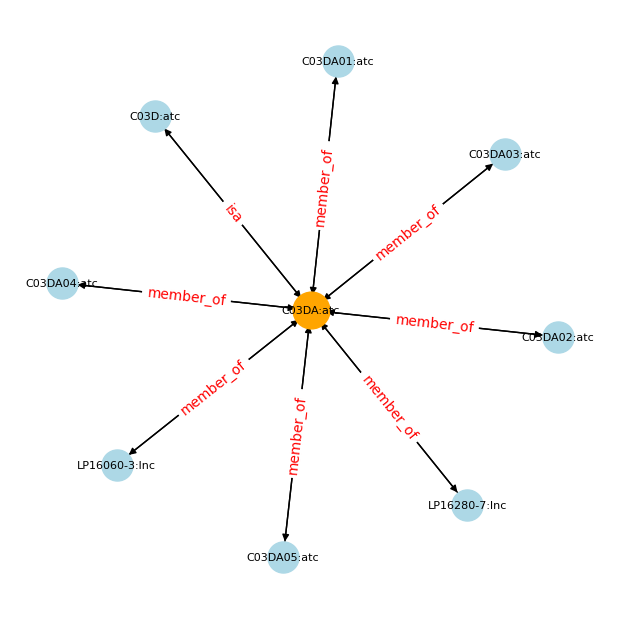

In [106]:
node_id = 'C03DA:atc'

import networkx as nx
import matplotlib.pyplot as plt

# Ego-graph: includes the node and all nodes 1 step away (neighbors)
ego = nx.ego_graph(G, node_id, radius=1)

# Draw with labels
plt.figure(figsize=(6,6))
pos = nx.spring_layout(ego)
nx.draw(ego, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=8)
edge_labels = nx.get_edge_attributes(ego, 'relationship')
nx.draw_networkx_edge_labels(ego, pos, edge_labels=edge_labels, font_color='red')
nx.draw_networkx_nodes(ego, pos, nodelist=[node_id], node_color="orange", node_size=700)
plt.show()